<font size ='4'> Predicitve Modeling: New York Property Prices </font>

Data Source:
https://data.world/dataquest/nyc-property-sales-data/workspace/file?filename=NYC_property_sales.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy import stats
from scipy.stats import zscore
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', '{:,.0f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Import Data

In [3]:
house=pd.read_csv('Data/NYC_property_sales.csv')

In [4]:
house.shape

(38177, 20)

In [5]:
house.head(3)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
0,Bronx,Bathgate,01 One Family Dwellings,1,3030,62,A1,4463 Park Avenue,NaN,"10,457",1,0,1,1578,1470,1899,1,A1,455000,2018-11-28T00:00:00Z
1,Bronx,Bathgate,01 One Family Dwellings,1,3030,70,A1,4445 Park Avenue,NaN,"10,457",1,0,1,1694,1497,1899,1,A1,388500,2019-07-23T00:00:00Z
2,Bronx,Bathgate,01 One Family Dwellings,1,3039,63,A1,469 E 185th St,NaN,"10,458",1,0,1,1650,1296,1910,1,A1,419000,2018-12-20T00:00:00Z


In [6]:
house.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'building_class_at_present',
       'address', 'apartment_number', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'tax_class_at_time_of_sale',
       'building_class_at_time_of_sale', 'sale_price', 'sale_date'],
      dtype='object')

<font size ='5'> Data Cleaning </font>

<font size = '3'> Data Types </font>

In [7]:
house.dtypes

borough                            object
neighborhood                       object
building_class_category            object
tax_class_at_present               object
block                               int64
lot                                 int64
building_class_at_present          object
address                            object
apartment_number                   object
zip_code                          float64
residential_units                   int64
commercial_units                    int64
total_units                         int64
land_square_feet                    int64
gross_square_feet                   int64
year_built                          int64
tax_class_at_time_of_sale           int64
building_class_at_time_of_sale     object
sale_price                          int64
sale_date                          object
dtype: object

Converting and adding time based variables

In [8]:
house['sale_date'] = pd.to_datetime(house['sale_date'])
house['year_month'] = house['sale_date'].dt.to_period('M')
house['year']=house['sale_date'].dt.year

/var/folders/d3/xxdfzd3n6lq70gynyy5khm800000gn/T/ipykernel_45411/291521357.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  house['year_month'] = house['sale_date'].dt.to_period('M')


<font size ='3'> Missing Values </font>

In [9]:
house.isna().sum()

borough                               0
neighborhood                          0
building_class_category               0
tax_class_at_present                  0
block                                 0
lot                                   0
building_class_at_present             0
address                               0
apartment_number                  26109
zip_code                             33
residential_units                     0
commercial_units                      0
total_units                           0
land_square_feet                      0
gross_square_feet                     0
year_built                            0
tax_class_at_time_of_sale             0
building_class_at_time_of_sale        0
sale_price                            0
sale_date                             0
year_month                            0
year                                  0
dtype: int64

Filling in null zip code values

In [10]:
null_zip_code_rows= house[house['zip_code'].isna()]
null_zip_code_rows.index

Int64Index([ 7353, 19356, 19357, 19358, 19359, 19360, 19361, 19362, 19363,
            19364, 22395, 23040, 23043, 25207, 25219, 25225, 25228, 26793,
            27374, 28055, 28689, 28690, 29431, 30223, 30224, 30292, 31393,
            32209, 32214, 32215, 32220, 32697, 36723],
           dtype='int64')

In [11]:
null_zip_code_rows.head(2)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,year_month,year
7353,Brooklyn,Canarsie,22 Store Buildings,4,8240,4,K1,94-09 Avenue L,NaN,NaN,0,3,3,5000,5000,1931,4,K1,3125000,2019-07-19 00:00:00+00:00,2019-07,2019
19356,Manhattan,Tribeca,13 Condos - Elevator Apartments,2,16,3624,R4,"2 River Terrace, 4c",4C,NaN,0,0,0,0,1088,2006,2,R4,1678000,2019-01-10 00:00:00+00:00,2019-01,2019


In [12]:
indices = [7353, 19356, 19357, 19358, 19359, 19360, 19361, 19362, 19363, 19364, 22395, 23040, 23043, 25207, 25219, 25225, 25228, 26793,
           27374, 28055, 28689, 28690, 29431, 30223, 30224, 30292, 31393, 32209, 32214, 32215, 32220, 32697, 36723]
zip_codes= [11236, 10282, 10282, 10282, 10282, 10282, 10282, 10282, 10282, 11364, 11357, 11354, 11358, 11355, 11355, 11355, 11414, 11432, 00000, 
            11364, 11364, 11428, 00000, 11385, 11694, 11433, 11434, 11434, 11434, 11434, 11434, 11429, 10306]
for idx, zip_code in zip(indices, zip_codes):
    house.loc[idx, 'zip_code'] = zip_code

house = house.drop([28055, 30223], axis=0)
house = house.reset_index(drop=True)

In [13]:
house.zip_code.isna().sum()

0

Drop apartment number column. Not relevant to analysis and many properties are not apartments.

In [14]:
house=house.drop('apartment_number', axis=1)

<font size = '3'> Duplicate Values </font>

In [15]:
house.duplicated().sum()

0

Set all string columns to lowercase

In [16]:
house = house.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

<font size ='3' > Outliers </font>

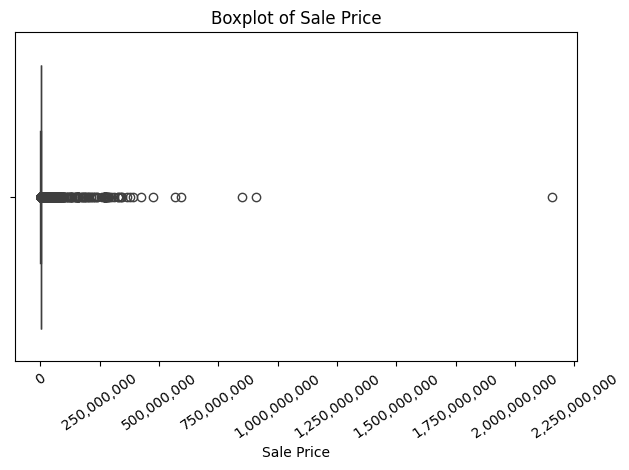

In [17]:
sns.boxplot(x=house['sale_price'])
plt.title('Boxplot of Sale Price')
plt.xlabel('Sale Price')
plt.xticks(rotation=35)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

In [18]:
house['log_sale_price'] = np.log(house['sale_price'])

house['log_price_z'] = stats.zscore(house['log_sale_price'])

price_outliers = house.query('log_price_z > 3 | log_price_z < -3')
print(f"Number of outliers (log-transformed): {price_outliers.shape[0]}")

Number of outliers (log-transformed): 837


In [19]:
price_outliers.building_class_category.value_counts()

13 condos - elevator apartments               157
02 two family dwellings                        90
08 rentals - elevator apartments               69
01 one family dwellings                        67
21 office buildings                            55
44 condo parking                               54
43 condo office buildings                      50
30 warehouses                                  49
07 rentals - walkup apartments                 44
47 condo non-business storage                  35
22 store buildings                             26
26 other hotels                                16
27 factories                                   14
03 three family dwellings                      13
46 condo store buildings                       13
28 commercial condos                           12
29 commercial garages                          12
45 condo hotels                                 7
23 loft buildings                               7
25 luxury hotels                                7


Capping biggest outliers at third z-score

In [20]:
log_sale_price = np.log1p(house['sale_price'])
log_z_scores = zscore(log_sale_price)
threshold = 3

capped_log_sale_price = log_sale_price.apply(
    lambda x: log_sale_price.mean() + threshold * log_sale_price.std() if x > log_sale_price.mean() + threshold * log_sale_price.std() else x
)
capped_sale_price = np.expm1(capped_log_sale_price)
house['sale_price'] = capped_sale_price

Outliers: Given the target variable is property sale price, there is a wide range of values. The data contains sale prices for different property types, including entire apartment complexes, warehouses, and hotels. Therefore, there are outliers giving the data a right skew. 837 outliers were identified based on a Z-score of 3 from log-transformed sale prices. These outliers were capped at the Z-score threshold value, which represents the point beyond which only 0.3% of the data lies. This method reduces the impact of extreme values while retaining the majority of the data. Certain property types have less than 100 data points, and this will be revisited later during the model training process.

Adding Subcategories for building types

In [21]:
def categorize_building_type(building_class):
    category_mapping = {
        '01': 'Residential - Family Dwellings', '02': 'Residential - Family Dwellings', '03': 'Residential - Family Dwellings',
        '13': 'Residential - Condominiums', '15': 'Residential - Condominiums', '12': 'Residential - Condominiums',
        '07': 'Residential - Rentals', '14': 'Residential - Rentals', '08': 'Residential - Rentals',
        '22': 'Commercial - Store Buildings',
        '44': 'Commercial - Condo Parking',
        '46': 'Commercial - Condo Store Buildings',
        '21': 'Commercial - Office Buildings', '43': 'Commercial - Office Buildings',
        '30': 'Commercial - Warehouse/Commercial Garages', '29': 'Commercial - Warehouse/Commercial Garages',
        '37': 'Commercial - Religious Facilities',
        '45': 'Commercial - Hotels',
        '33': 'Commercial - Educational/Health Facilities', '32': 'Commercial - Educational/Health Facilities',
        '23': 'Commercial - Loft Buildings',
        '35': 'Commercial - Public/Cultural Facilities',
        '36': 'Commercial - Outdoor Recreational Facilities',
        '25': 'Commercial - Luxury Hotels'
    }
    for prefix, category in category_mapping.items():
        if building_class.startswith(prefix):
            return category
    return 'Specialized - Other'

house['sub_category'] = house['building_class_category'].apply(categorize_building_type)

In [22]:
house['sub_category'].value_counts()

Residential - Family Dwellings                  22710
Residential - Condominiums                       9765
Residential - Rentals                            1933
Specialized - Other                              1619
Commercial - Store Buildings                      526
Commercial - Condo Parking                        512
Commercial - Office Buildings                     480
Commercial - Warehouse/Commercial Garages         320
Commercial - Condo Store Buildings                 85
Commercial - Religious Facilities                  76
Commercial - Hotels                                53
Commercial - Educational/Health Facilities         49
Commercial - Public/Cultural Facilities            15
Commercial - Loft Buildings                        15
Commercial - Luxury Hotels                         13
Commercial - Outdoor Recreational Facilities        4
Name: sub_category, dtype: int64

Broader Categories:

In [23]:
def categorize_type(sub_category):
    if 'Residential' in sub_category:
        return 'Residential'
    elif 'Commercial' in sub_category:
        return 'Commercial'
    else:
        return 'Specialized'

house['category'] = house['sub_category'].apply(categorize_type)

Year Built:

Adding the homes built before 1800 as "Pre-1800s." The data contains 2572 entries with the year 0 on it.

In [24]:
historical_years = [0, 1030, 1800, 1821, 1826, 1834, 1835, 1838, 1840, 1841, 1844, 
                    1845, 1850, 1851, 1856, 1857, 1860, 1870]

historical_homes = house[house['year_built'].isin(historical_years)]
year_counts = historical_homes['year_built'].value_counts().sort_index()
print(year_counts)

0       2572
1030       1
1800      13
1821       1
1826       1
1834       1
1835       1
1838       1
1840       3
1841       2
1844       1
1845       4
1850       1
1851       2
1856       2
1857       1
1860       1
1870       5
Name: year_built, dtype: int64


In [25]:
house['year_built'] = house['year_built'].replace({0: 'Pre-1800', 1030: 'Pre-1800'})

Convert Column to String

In [26]:
house['year_built'] = house['year_built'].astype(str)

<font size = '5'> Exploratory Data Analysis </font>

<font size='3'> Target Variable: Sale Price </font>

In [27]:
house.sale_price.describe()

count       38,175
mean     1,543,040
std      2,713,468
min         10,040
25%        525,000
50%        760,000
75%      1,280,000
max     17,653,312
Name: sale_price, dtype: float64

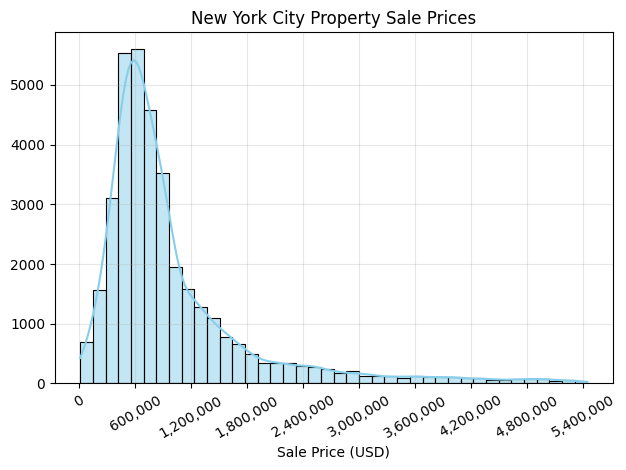

In [28]:
upper_limit = house['sale_price'].quantile(0.95)
plot_data = house[house['sale_price'] <= upper_limit]

sns.histplot(plot_data['sale_price'], bins=40, kde=True, color='skyblue', edgecolor='black')

plt.title('New York City Property Sale Prices')
plt.xlabel('Sale Price (USD)')
plt.xticks(rotation=30)
plt.ylabel('')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<font size='3'> Exploring predictor variables </font>
 - property type, borough, square footage

Property Type

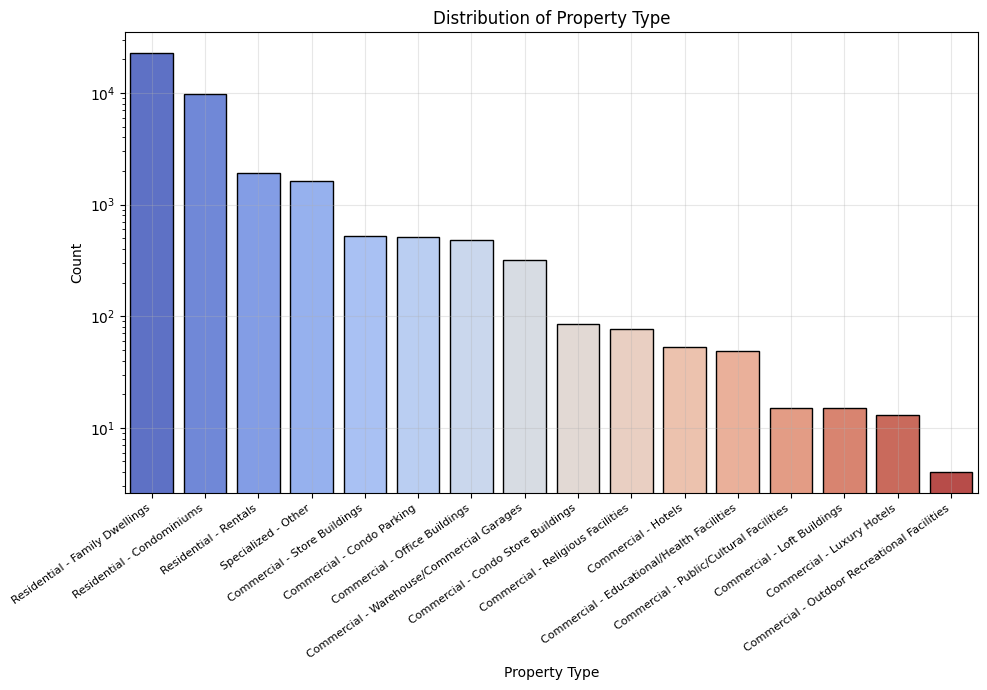

In [29]:
subcategory_counts=house['sub_category'].value_counts()
plt.figure(figsize=(10, 7))
sns.barplot(x=subcategory_counts.index, y=subcategory_counts.values, palette='coolwarm', edgecolor='Black')
plt.title('Distribution of Property Type')
plt.xlabel('Property Type')
plt.xticks(rotation=35, ha='right', fontsize=8)
plt.ylabel('Count')
plt.yscale('log')
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()

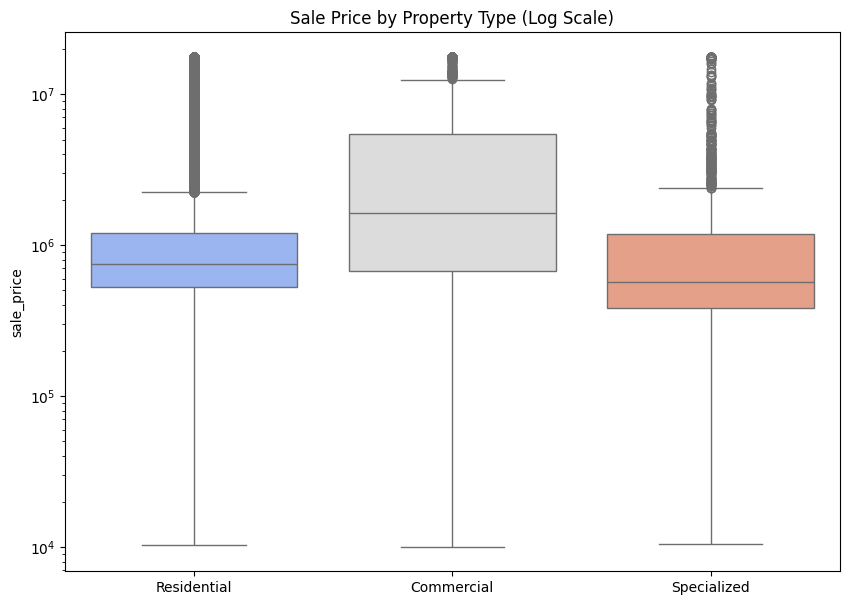

In [30]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=house, x='category', y='sale_price', palette='coolwarm')
plt.yscale('log')
plt.xlabel('')
plt.title('Sale Price by Property Type (Log Scale)')
plt.show()

Borough

In [31]:
borough_distribution = house['borough'].value_counts()
borough_distribution

queens           11953
brooklyn         10888
manhattan         6572
staten island     4837
bronx             3925
Name: borough, dtype: int64

In [32]:
borough_palette = sns.color_palette("coolwarm", n_colors=len(house['borough'].unique()))
borough_to_color = {borough: borough_palette[i] for i, borough in enumerate(house['borough'].value_counts().index)}

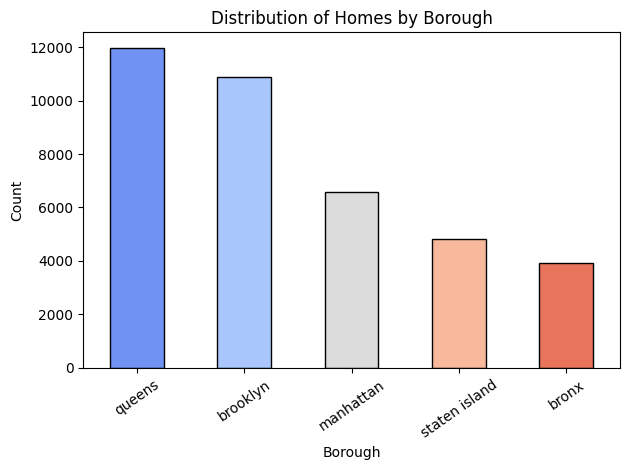

In [33]:
borough_distribution = house['borough'].value_counts().sort_values(ascending=False)
borough_distribution.plot(kind='bar', color=[borough_to_color[borough] for borough in borough_distribution.index], edgecolor='black')
plt.title('Distribution of Homes by Borough')
plt.xlabel('Borough')
plt.xticks(rotation=35)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

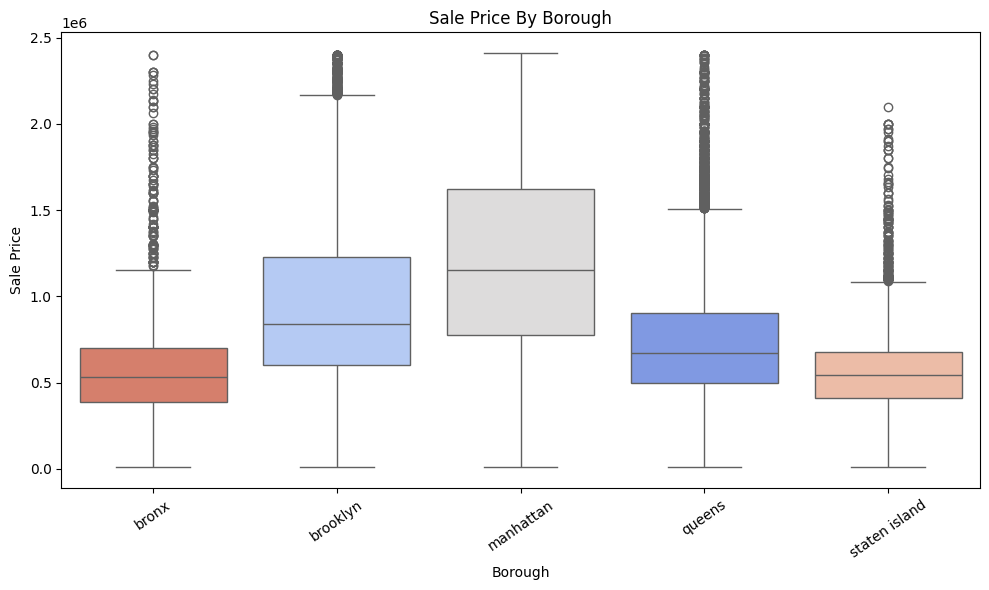

In [34]:
Q1_price = house['sale_price'].quantile(0.25)
Q3_price = house['sale_price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

filtered_house = house[house['sale_price'].between(lower_bound_price, upper_bound_price)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_house, x='borough', y='sale_price', palette=borough_to_color)
plt.title('Sale Price By Borough')
plt.xlabel('Borough')
plt.ylabel('Sale Price')
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()

Square Footage

Excluding values greater than 1.5x the IQR

In [35]:
Q1 = house['gross_square_feet'].quantile(0.25)
Q3 = house['gross_square_feet'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = house[house['gross_square_feet'].between(lower_bound, upper_bound)]

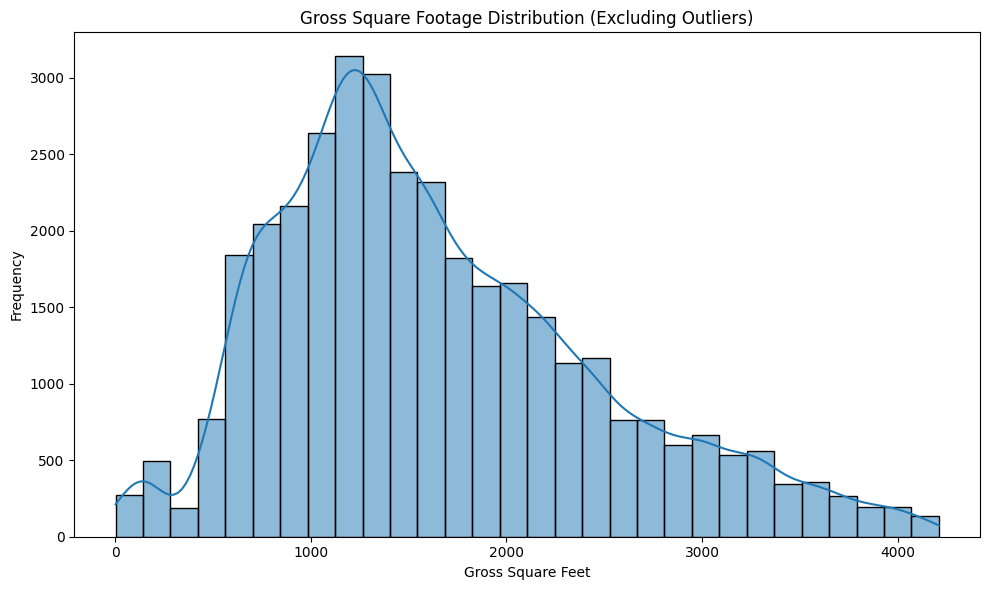

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['gross_square_feet'], kde=True, bins=30)
plt.title('Gross Square Footage Distribution (Excluding Outliers)')
plt.xlabel('Gross Square Feet')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<font size='3'> Correlation </font>

In [37]:
house.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'building_class_at_present',
       'address', 'zip_code', 'residential_units', 'commercial_units',
       'total_units', 'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date', 'year_month', 'year', 'log_sale_price',
       'log_price_z', 'sub_category', 'category'],
      dtype='object')

In [38]:
house = house.drop(['log_price_z', 'log_sale_price'], axis=1)

Numeric Variables:
- gross_square_feet, total_units, residential_units, commercial_units, land_square_feet, lot, year, block

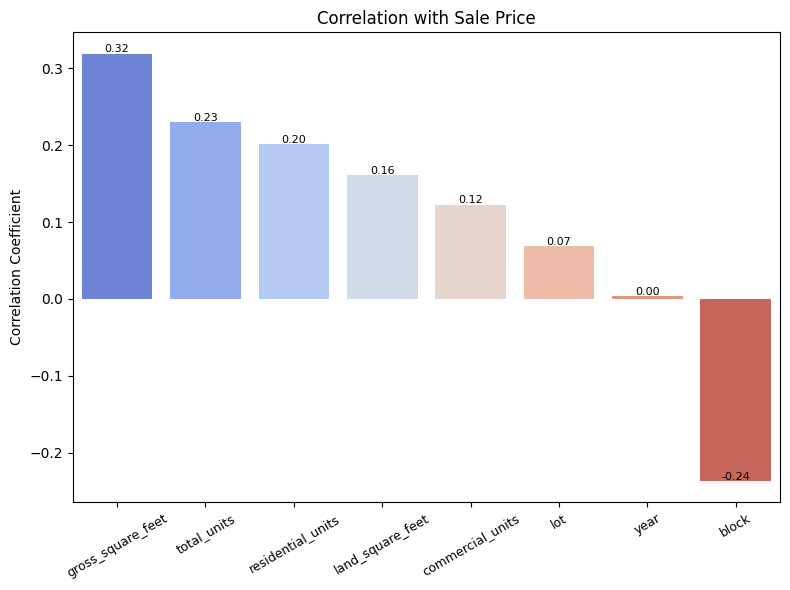

In [39]:
exclude_vars = ['tax_class_at_time_of_sale', 'zip_code']
correlation_matrix = house.drop(columns=exclude_vars).corr()

sale_price_corr = correlation_matrix['sale_price'].drop('sale_price').sort_values(ascending=False)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sale_price_corr.index, y=sale_price_corr.values, palette='coolwarm')
plt.title('Correlation with Sale Price')
plt.xticks(rotation=30, fontsize=9)
plt.xlabel('')
plt.ylabel('Correlation Coefficient')

for i, v in enumerate(sale_price_corr.values):
    ax.text(i, v - 0.001, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

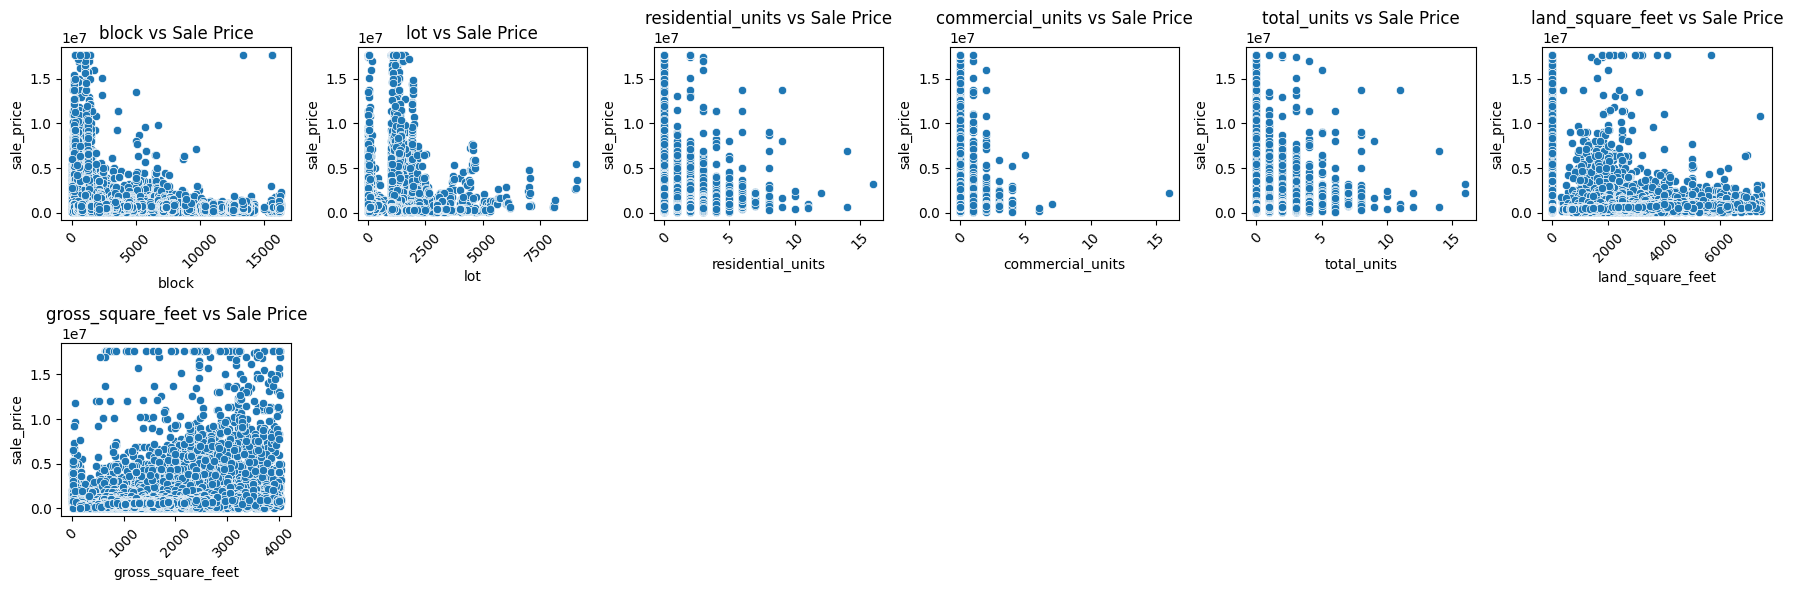

In [40]:
numeric_columns = house.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in ['sale_price', 'tax_class_at_time_of_sale', 'zip_code', 'year']:
    numeric_columns.remove(col)

square_feet_columns = ['land_square_feet', 'gross_square_feet']

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[df[column].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)]

filtered_house = house.copy()
for column in square_feet_columns:
    filtered_house = remove_outliers(filtered_house, column)

plt.figure(figsize=(18, 6)) 
for i, column in enumerate(numeric_columns):
    plt.subplot(2, 6, i + 1)
    sns.scatterplot(data=filtered_house, x=column, y='sale_price')
    plt.title(f'{column} vs Sale Price', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Categorical

- borough, neighborhood, building_class_category, tax_class_at_present, address, zip_code, tax_class_at_time_of_sale, building_class_at_time_of_sale, sub_category, category

In [41]:
categorical_columns = ['borough', 'neighborhood', 'building_class_category', 'tax_class_at_present', 
                       'building_class_at_present', 'zip_code', 'tax_class_at_time_of_sale', 
                       'building_class_at_time_of_sale', 'sub_category', 'category']

ANOVA Test

In [42]:
def run_anova_f_oneway(data, dependent_var, independent_var):
    unique_categories = data[independent_var].unique()
    category_groups = [data[data[independent_var] == cat][dependent_var] for cat in unique_categories]
    f_stat, p_value = stats.f_oneway(*category_groups)
    print(f"ANOVA for {independent_var}: F-statistic = {f_stat}, p-value = {p_value}\n")

for var in categorical_columns:
    run_anova_f_oneway(house, 'sale_price', var)

ANOVA for borough: F-statistic = 1618.2002065557206, p-value = 0.0

ANOVA for neighborhood: F-statistic = 48.57692962227674, p-value = 0.0

ANOVA for building_class_category: F-statistic = 396.27288067761594, p-value = 0.0

ANOVA for tax_class_at_present: F-statistic = 898.931180713983, p-value = 0.0

ANOVA for building_class_at_present: F-statistic = 146.98620341945323, p-value = 0.0

ANOVA for zip_code: F-statistic = 60.797462195584366, p-value = 0.0

ANOVA for tax_class_at_time_of_sale: F-statistic = 2985.187894227914, p-value = 0.0

ANOVA for building_class_at_time_of_sale: F-statistic = 146.21971471124536, p-value = 0.0

ANOVA for sub_category: F-statistic = 608.5330208335977, p-value = 0.0

ANOVA for category: F-statistic = 1335.3924930327414, p-value = 0.0



The p-value of 0 because there are many categories per variable. Based on the ANOVA test, I won't remove any variables for the initial predictive model.

<font size='5'> Time Based Exploration </font>

- Variables: 
    - sale_date (primary time reference)
    - year_month
    - year_built
    - year
- Decomposition
- ARIMA

The data is a time series with exogenous variables. The target variable, sale_price, is stored over time. 

Remove time, keep date.

In [43]:
house['sale_date'] = house['sale_date'].dt.tz_localize(None).dt.date

In [44]:
house.head(1)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,year_month,year,sub_category,category
0,bronx,bathgate,01 one family dwellings,1,3030,62,a1,4463 park avenue,"10,457",1,0,1,1578,1470,1899,1,a1,"455,000",2018-11-28,2018-11,2018,Residential - Family Dwellings,Residential


In [45]:
date_range = house['sale_date'].agg(['min', 'max'])
print(date_range)

min    2018-11-01
max    2019-10-31
Name: sale_date, dtype: object


<font size ='3' > Initial Visualizations </font>

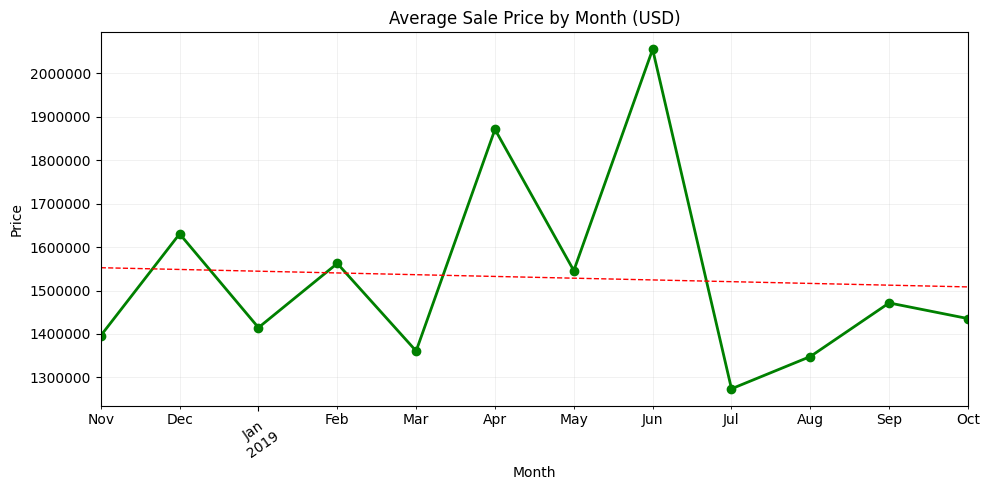

In [46]:
plt.figure(figsize=(10, 5))

price_trend = house.groupby('year_month')['sale_price'].mean()
price_trend.plot(kind='line', color='g', marker='o', linestyle='-', linewidth=2)

x = np.arange(len(price_trend))
y = price_trend.values
coefficients = np.polyfit(x, y, 1)
trend_line = np.polyval(coefficients, x)

plt.plot(price_trend.index, trend_line, color='red', linestyle='--', linewidth=1)

plt.title('Average Sale Price by Month (USD)')
plt.xlabel('Month')
plt.xticks(rotation=35)
plt.ylabel('Price')
plt.grid(True, which='both', axis='both', linewidth=0.4, alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

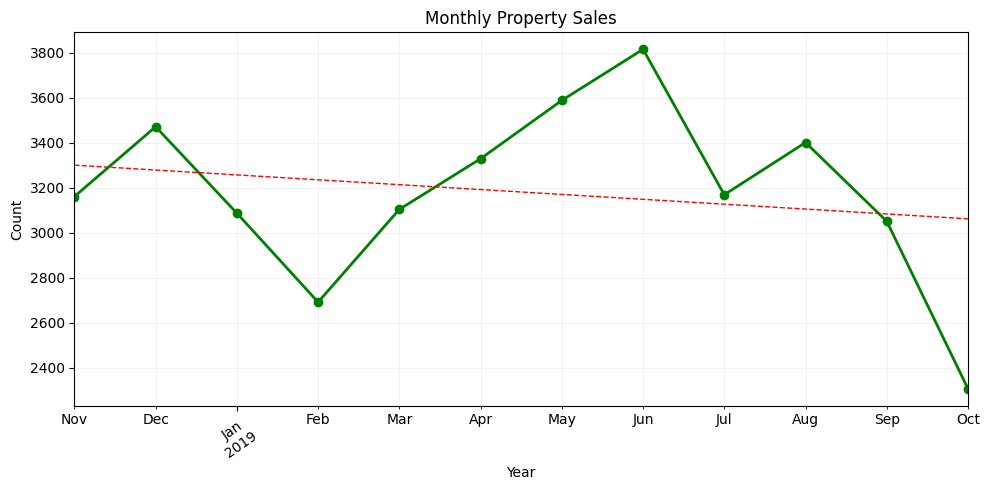

In [47]:
plt.figure(figsize=(10, 5))

date_trend = house.groupby('year_month').size()
date_trend.plot(kind='line', color='g', marker='o', linestyle='-', linewidth=2)

x = np.arange(len(date_trend))
y = date_trend.values
coefficients = np.polyfit(x, y, 1)
trend_line = np.polyval(coefficients, x)

plt.plot(date_trend.index, trend_line, color='red', linestyle='--', linewidth=1)

plt.title('Monthly Property Sales')
plt.xlabel('Year')
plt.xticks(rotation=35)
plt.ylabel('Count')
plt.grid(True, which='both', axis='both', linewidth=0.4, alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

<font size='3'> Decomposition </font>

Break down sale_price to identify trend, seasonality, residuals.

D603 Task 3 as reference

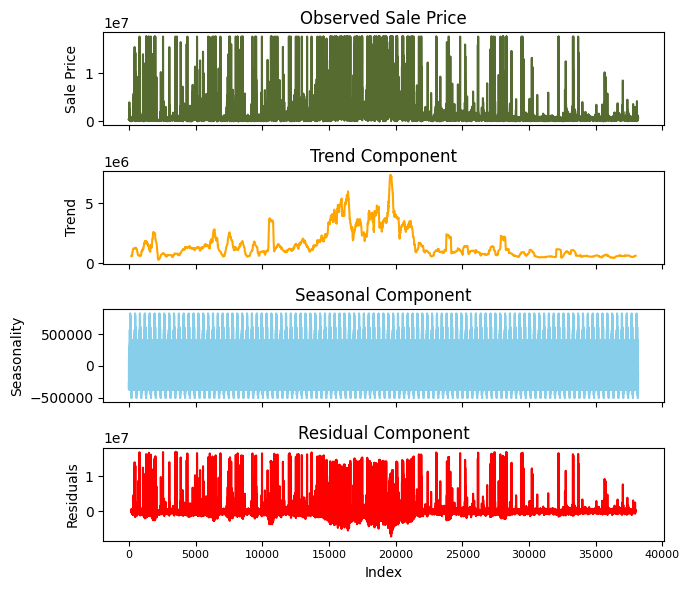

In [48]:
decomposition = seasonal_decompose(house['sale_price'], model='additive', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7, 6), sharex=True)

ax1.plot(decomposition.observed, label='Observed', color='darkolivegreen')
ax1.set_ylabel('Sale Price')
ax1.set_title('Observed Sale Price')

ax2.plot(decomposition.trend, label='Trend', color='orange')
ax2.set_ylabel('Trend')
ax2.set_title('Trend Component')

ax3.plot(decomposition.seasonal, label='Seasonal', color='skyblue')
ax3.set_ylabel('Seasonality')
ax3.set_title('Seasonal Component')

ax4.plot(decomposition.resid, label='Residual', color='red')
ax4.set_ylabel('Residuals')
ax4.set_xlabel('Index')
ax4.set_title('Residual Component')

plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()

Stationarity Check

In [49]:
house_sorted = house.copy()
house_sorted = house_sorted.sort_values(by='sale_date')

result = adfuller(house_sorted['sale_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'    {key}:{value}')

ADF Statistic: -23.7174620232045
p-value: 0.0
Critical Values:
    1%:-3.4305214622101787
    5%:-2.8616157822562776
    10%:-2.5668103364790587


The data is inherently stationary. Mean, variance, and autocorrelation are constant over time.

<font size ='5'> ARIMA </font>

Forecasting property sale prices based on temporal dependencies. 
- use chronlogically ordered data. house_sorted
- aggregate sales on the same date.
- log scale due to wide range of values

In [50]:
arma_data = house_sorted.copy()
arma_data['unique_sale_date'] = pd.to_datetime(arma_data['sale_date'])
arma_data['unique_sale_date'] += pd.to_timedelta(arma_data.groupby('sale_date').cumcount(), unit='s')

arma_data.set_index('unique_sale_date', inplace=True)
arma_data = arma_data.asfreq('D')
arma_data = arma_data.resample('D').mean()

arma_data['log_sale_price'] = np.log(arma_data['sale_price'])
arma_data['log_sale_price'] = arma_data['log_sale_price'].interpolate(method='time')

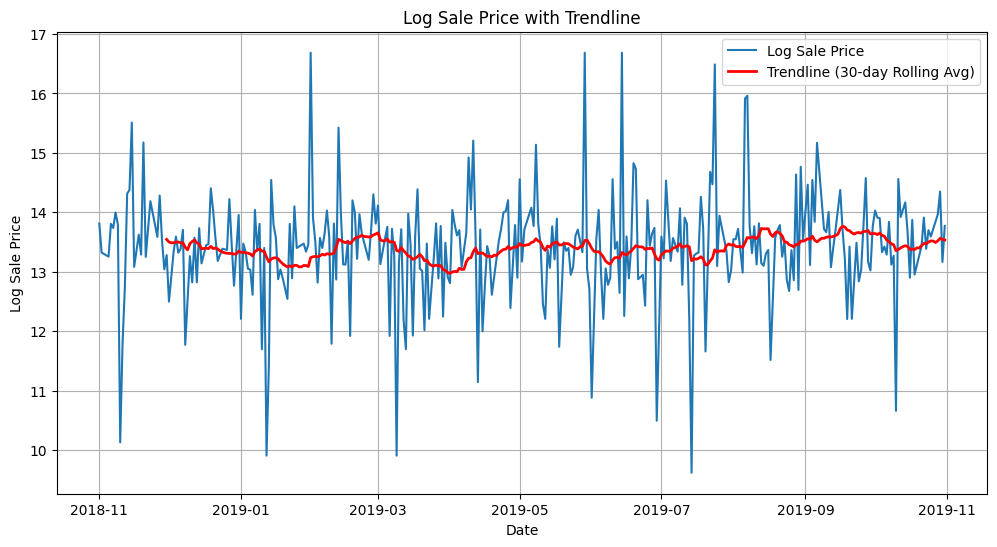

In [51]:
arma_data['rolling_mean'] = arma_data['log_sale_price'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(arma_data.index, arma_data['log_sale_price'], label='Log Sale Price')
plt.plot(arma_data.index, arma_data['rolling_mean'], color='red', label='Trendline (30-day Rolling Avg)', linewidth=2)
plt.title('Log Sale Price with Trendline')
plt.xlabel('Date')
plt.ylabel('Log Sale Price')
plt.legend()
plt.grid()
plt.show()

<font size ='3'> Train/Test/Split </font>

In [52]:
split_index = int(len(arma_data) * 0.85) 
arma_train = arma_data.iloc[:split_index]
arma_test = arma_data.iloc[split_index:]

print(f'Number of rows in train: {len(arma_train)}')
print(f'Number of rows in test: {len(arma_test)}')

Number of rows in train: 310
Number of rows in test: 55


<font size ='3'> Select Parameters </font>

In [53]:
from pmdarima import auto_arima
auto_model = auto_arima(arma_train['log_sale_price'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2491.542, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2117.090, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1836.227, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1674.287, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=848.098, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1545.428, Time=0.08 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=835.532, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=834.056, Time=0.03 sec
 ARIM

<font size ='3'> Train Model </font>
- p= 1
- q= 0
- d= 0
- Filter out extreme outlier past z-score 3.

In [54]:
mean_log_sale_price = arma_train['log_sale_price'].mean()
std_log_sale_price = arma_train['log_sale_price'].std()

arma_train_filtered = arma_train[
    (arma_train['log_sale_price'] >= mean_log_sale_price - threshold * std_log_sale_price) & 
    (arma_train['log_sale_price'] <= mean_log_sale_price + threshold * std_log_sale_price)
]

seasonal_order = (1, 1, 1, 12)

arima_model_filtered = SARIMAX(arma_train_filtered['log_sale_price'], order=(1, 0, 0), seasonal_order=seasonal_order)
arima_results_filtered = arima_model_filtered.fit()

print(arima_results_filtered.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22289D+00    |proj g|=  3.29957D-01

At iterate    5    f=  1.14987D+00    |proj g|=  9.06715D-02


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.13936D+00    |proj g|=  9.26919D-03

At iterate   15    f=  1.13913D+00    |proj g|=  1.44760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   4.313D-06   1.139D+00
  F =   1.1391257323868489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                       
Dep. Variable:                       log_sale_price   No. Observations:                  301
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -342.877
Date:               

Examine Training Residuals

In [55]:
residuals = arima_results_filtered.resid

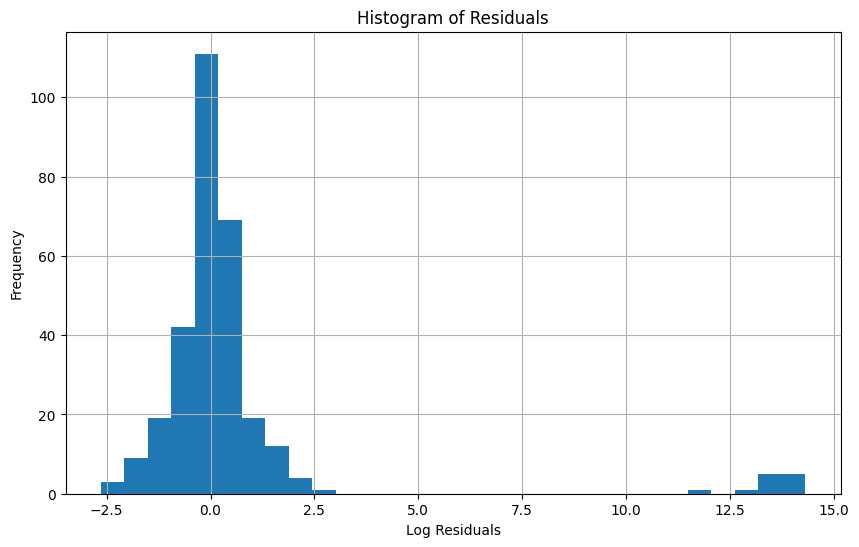

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Log Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Residuals should be white noise

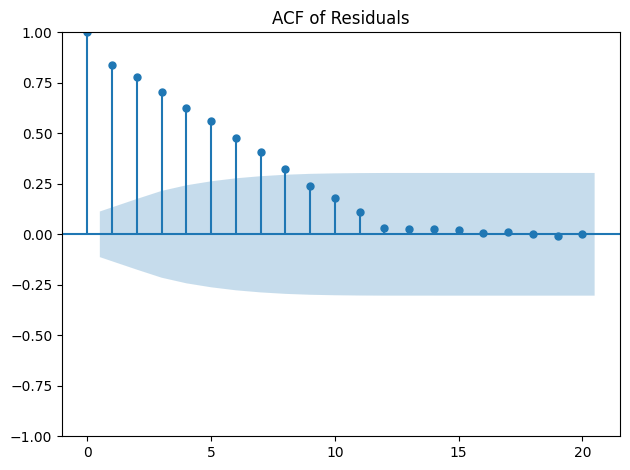

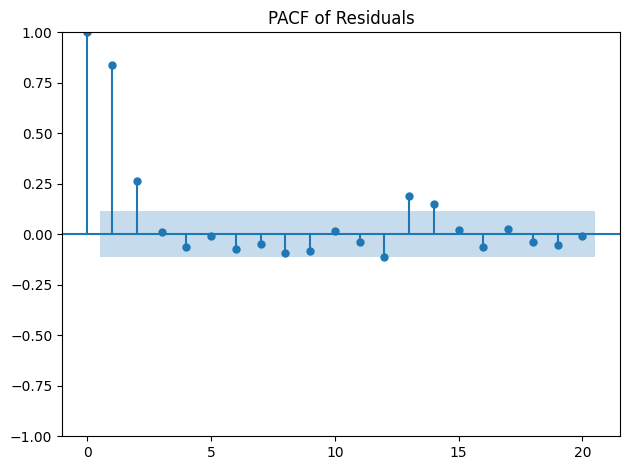

In [57]:
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

plot_pacf(residuals, lags=20)
plt.title('PACF of Residuals')
plt.tight_layout()
plt.show()

<font size='4'> Forecast </font>

In [58]:
forecast_steps = len(arma_test)
forecast_log = arima_results_filtered.forecast(steps=forecast_steps)
forecast = np.exp(forecast_log)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


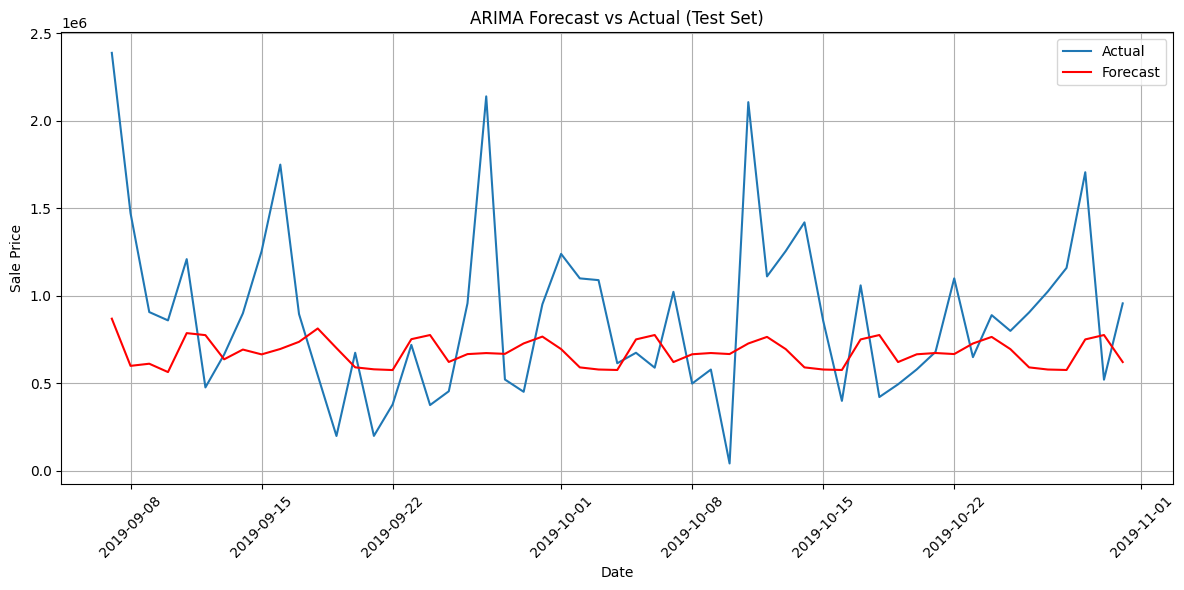

In [59]:
forecast_orig = np.exp(forecast_log)
actual_price = np.exp(arma_test['log_sale_price'])

plt.figure(figsize=(12, 6))
plt.plot(arma_test.index, actual_price, label='Actual')
plt.plot(arma_test.index, forecast_orig, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sale Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Smooth Data for Plotting

In [60]:
all_prices = np.concatenate([
    np.exp(arma_train['log_sale_price']),
    actual_price,
    forecast_orig
])

q1, q3 = np.percentile(all_prices, [25, 75])
iqr = q3 - q1
threshold = 3 * iqr
upper_bound_display = q3 + threshold

train_masked = np.where(np.exp(arma_train['log_sale_price']) > upper_bound_display, np.nan, np.exp(arma_train['log_sale_price']))
actual_masked = np.where(actual_price > upper_bound_display, np.nan, actual_price)
forecast_masked = np.where(forecast_orig > upper_bound_display, np.nan, forecast_orig)

train_masked_interp = pd.Series(train_masked, index=arma_train.index).interpolate()
actual_masked_interp = pd.Series(actual_masked, index=arma_test.index).interpolate()
forecast_masked_interp = pd.Series(forecast_masked, index=arma_test.index).interpolate()

train_resampled = pd.Series(train_masked_interp, index=arma_train.index).resample('W').mean() 
actual_resampled = pd.Series(actual_masked_interp, index=arma_test.index).resample('W').mean()
forecast_resampled = pd.Series(forecast_masked_interp, index=arma_test.index).resample('W').mean()

In [61]:
residuals = actual_resampled - forecast_resampled
residual_std = residuals.std()

confidence_intervals = pd.DataFrame({
    'lower': forecast_resampled - (1.96 * residual_std), 
    'upper': forecast_resampled + (1.96 * residual_std)
}, index=forecast_resampled.index)

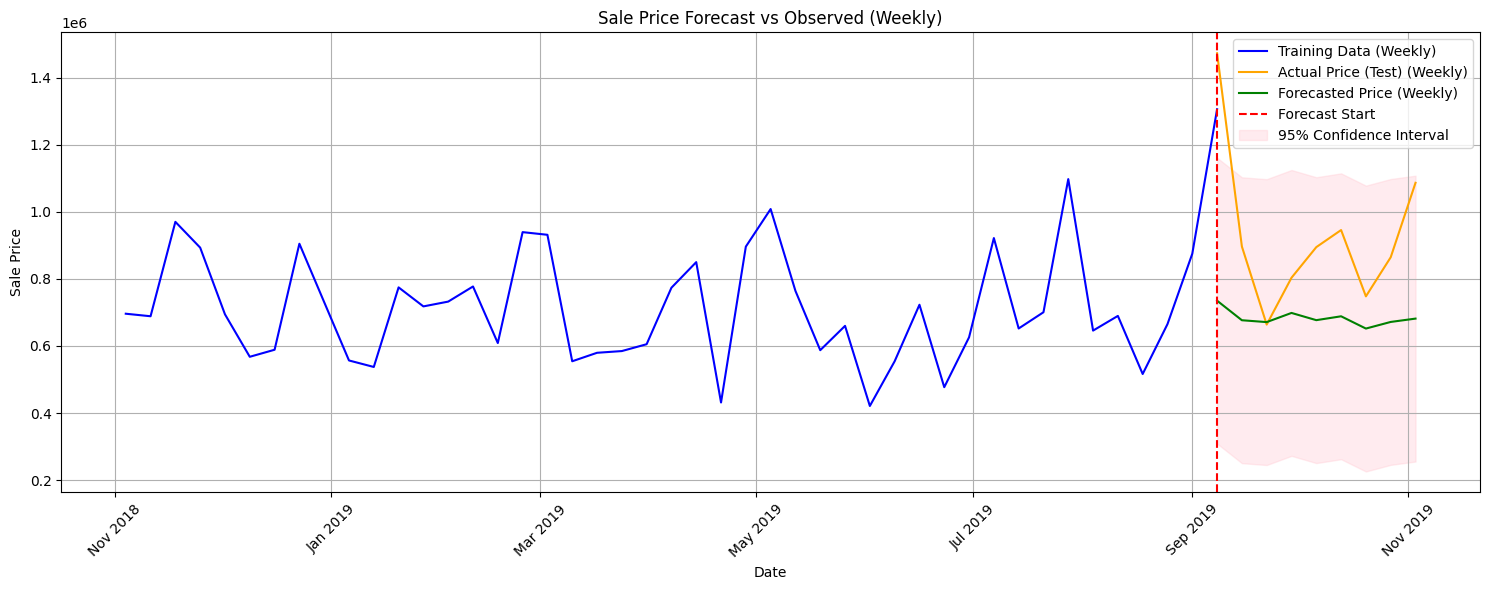

In [62]:
plt.figure(figsize=(15, 6))
plt.plot(train_resampled.index, train_resampled, label='Training Data (Weekly)', color='blue')
plt.plot(actual_resampled.index, actual_resampled, label='Actual Price (Test) (Weekly)', color='orange')
plt.plot(forecast_resampled.index, forecast_resampled, label='Forecasted Price (Weekly)', color='green')

plt.axvline(x=actual_resampled.index[0], color='red', linestyle='--', label='Forecast Start')

plt.fill_between(confidence_intervals.index, confidence_intervals['lower'], confidence_intervals['upper'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Sale Price Forecast vs Observed (Weekly)')
plt.xlabel('Date')
plt.ylabel('Sale Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

<font size ='3'> Evaluation of ARIMA Forecast </font>

In [63]:
forecast_residuals = actual_resampled - forecast_resampled
print("Average Forecast Error:", round(forecast_residuals.mean(), 2))

Average Forecast Error: 246954.42


In [64]:
max_value = arma_data['sale_price'].max()
min_value = arma_data['sale_price'].min()

print(f"Maximum Sale Price: {max_value:,.2f}")
print(f"Minimum Sale Price: {min_value:,.2f}")

Maximum Sale Price: 17,653,311.70
Minimum Sale Price: 15,000.00


<font size ='3'> ARIMA Summary </font>

The ARIMA model yielded an average forecasting error of $260,701.58. This is understandable, given the scale of property prices is quite large. The largest .03% of outliers were removed prior to training the model based on the third z-score. Additionaly, the logged property prices were used in training. These methods were utilized to give the model the best chance to learn from the data. Large outliers provide unnecessary noise, and make patterns harder to detect. 

Despite the efforts to mitigate outliers, large values still impacted the models performance. The training residuals graph shows spikes beyond 12.5 log residuals. This is due to properties that were expensive, but within 3 z-scores. The ARIMA model did capture the general property price trend. Forecasted prices on the test set mirrored the increases and decreases in the actual sale prices. This is apparent in the test set predictions plot.

It is interesting to note that the parameter search determined the best ARIMA model was the simplest. The order of (1,0,0) minimized the AIC score. A seasonal component was included to capture any cyclical patterns in the property sales data, maybe the model a SARIMA.

<font size='5'> Model Building </font>

<font size ='4'> Data Preprocessing </font>

In [65]:
house.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'building_class_at_present',
       'address', 'zip_code', 'residential_units', 'commercial_units',
       'total_units', 'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date', 'year_month', 'year', 'sub_category',
       'category'],
      dtype='object')

In [66]:
regression_data=house.drop(columns=['address', 'zip_code', 'block', 'lot', 'sale_date', 'neighborhood', 'building_class_at_present', 'tax_class_at_present', 'building_class_category', 'category']).copy()

Initial Correlation Check

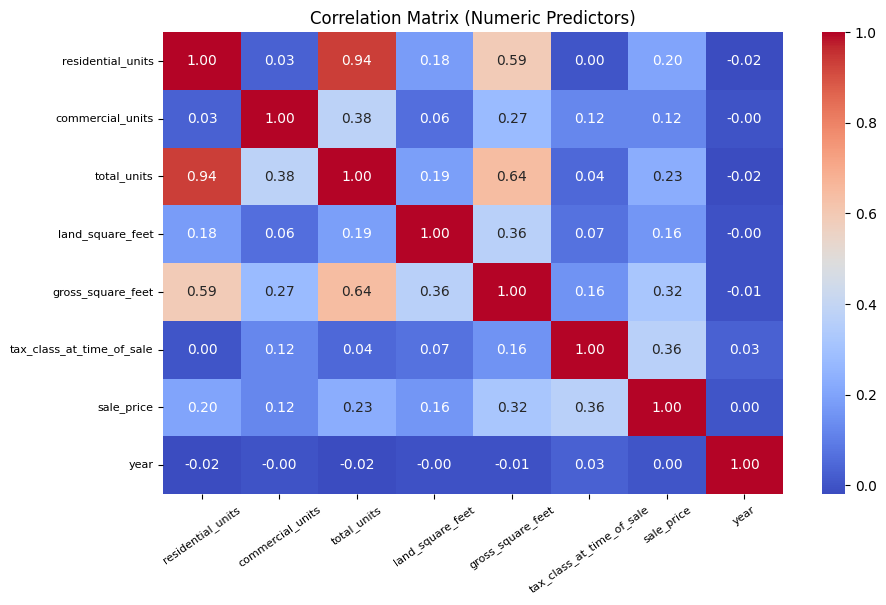

In [67]:
correlation_matrix = regression_data.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (Numeric Predictors)")
plt.xticks(rotation=35, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [68]:
regression_data=regression_data.drop(columns='residential_units')

Encoding
- building_class_at_time_of_sale: one hot
- borough: One hot
- tax_class_at_present: label
- sub_category: one hot
- tax_class_at_time_of_sale: label

In [69]:
one_hot_columns = ['borough', 
                   'building_class_at_time_of_sale',
                   'sub_category']

regression_data = pd.get_dummies(regression_data, columns=one_hot_columns, drop_first=True)

label_columns = [ 'tax_class_at_time_of_sale']
label_encoder = LabelEncoder()
for col in label_columns:
    regression_data[col] = label_encoder.fit_transform(regression_data[col])

regression_data.head()

,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,sale_price,year_month,year,borough_brooklyn,borough_manhattan,borough_queens,borough_staten island,building_class_at_time_of_sale_a1,building_class_at_time_of_sale_a2,building_class_at_time_of_sale_a3,building_class_at_time_of_sale_a4,building_class_at_time_of_sale_a5,building_class_at_time_of_sale_a6,building_class_at_time_of_sale_a7,building_class_at_time_of_sale_a9,building_class_at_time_of_sale_b1,building_class_at_time_of_sale_b2,building_class_at_time_of_sale_b3,building_class_at_time_of_sale_b9,building_class_at_time_of_sale_c0,building_class_at_time_of_sale_c1,building_class_at_time_of_sale_c2,building_class_at_time_of_sale_c3,building_class_at_time_of_sale_c4,building_class_at_time_of_sale_c5,building_class_at_time_of_sale_c7,building_class_at_time_of_sale_c9,building_class_at_time_of_sale_d1,building_class_at_time_of_sale_d2,building_class_at_time_of_sale_d3,building_class_at_time_of_sale_d5,building_class_at_time_of_sale_d6,building_class_at_time_of_sale_d7,building_class_at_time_of_sale_d8,building_class_at_time_of_sale_d9,building_class_at_time_of_sale_e1,building_class_at_time_of_sale_e2,building_class_at_time_of_sale_e7,building_class_at_time_of_sale_e9,building_class_at_time_of_sale_f1,building_class_at_time_of_sale_f2,building_class_at_time_of_sale_f4,building_class_at_time_of_sale_f5,building_class_at_time_of_sale_f8,building_class_at_time_of_sale_f9,building_class_at_time_of_sale_g1,building_class_at_time_of_sale_g2,building_class_at_time_of_sale_g3,building_class_at_time_of_sale_g4,building_class_at_time_of_sale_g8,building_class_at_time_of_sale_g9,building_class_at_time_of_sale_gu,building_class_at_time_of_sale_gw,building_class_at_time_of_sale_h1,building_class_at_time_of_sale_h2,building_class_at_time_of_sale_h3,building_class_at_time_of_sale_h4,building_class_at_time_of_sale_h6,building_class_at_time_of_sale_h7,building_class_at_time_of_sale_h8,building_class_at_time_of_sale_h9,building_class_at_time_of_sale_hb,building_class_at_time_of_sale_hr,building_class_at_time_of_sale_hs,building_class_at_time_of_sale_i4,building_class_at_time_of_sale_i5,building_class_at_time_of_sale_i6,building_class_at_time_of_sale_i7,building_class_at_time_of_sale_i9,building_class_at_time_of_sale_j1,building_class_at_time_of_sale_j2,building_class_at_time_of_sale_j9,building_class_at_time_of_sale_k1,building_class_at_time_of_sale_k2,building_class_at_time_of_sale_k3,building_class_at_time_of_sale_k4,building_class_at_time_of_sale_k5,building_class_at_time_of_sale_k6,building_class_at_time_of_sale_k7,building_class_at_time_of_sale_k8,building_class_at_time_of_sale_k9,building_class_at_time_of_sale_l1,building_class_at_time_of_sale_l2,building_class_at_time_of_sale_l8,building_class_at_time_of_sale_l9,building_class_at_time_of_sale_m1,building_class_at_time_of_sale_m2,building_class_at_time_of_sale_m3,building_class_at_time_of_sale_m4,building_class_at_time_of_sale_m9,building_class_at_time_of_sale_n2,building_class_at_time_of_sale_n9,building_class_at_time_of_sale_o1,building_class_at_time_of_sale_o2,building_class_at_time_of_sale_o3,building_class_at_time_of_sale_o4,building_class_at_time_of_sale_o5,building_class_at_time_of_sale_o6,building_class_at_time_of_sale_o7,building_class_at_time_of_sale_o8,building_class_at_time_of_sale_o9,building_class_at_time_of_sale_p1,building_class_at_time_of_sale_p2,building_class_at_time_of_sale_p4,building_class_at_time_of_sale_p5,building_class_at_time_of_sale_p6,building_class_at_time_of_sale_p8,building_class_at_time_of_sale_p9,building_class_at_time_of_sale_q2,building_class_at_time_of_sale_q7,building_class_at_time_of_sale_q9,building_class_at_time_of_sale_r1,building_class_at_time_of_sale_r2,building_class_at_time_of_sale_r3,building_class_at_time_of_sale_r4,building_class_at_time_of_sale_r5,building_class_at_time_of_sale_r6,building_class_at_time_of_sale_r7,building_class_at_time_of

In [70]:
regression_data.shape

(38175, 164)

Feature selection
- reduce the number of variables.
- Recursive Feature Elimination (RFE)

In [71]:
#Preprocess
regression_data_rfe = regression_data.drop('year_built', axis=1)
regression_data_rfe['year_month'] = regression_data_rfe['year_month'].dt.year

X = regression_data_rfe.drop('sale_price', axis=1)
y = regression_data_rfe['sale_price']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns
X_with_const = sm.add_constant(X_scaled)


In [72]:
model = sm.OLS(y, X_with_const)
results = model.fit()

p_values = results.pvalues[1:]
sorted_p_indices = p_values.argsort()
sorted_feature_names = feature_names[sorted_p_indices]

print("Features sorted by p-value:")
for feature, p_value in zip(sorted_feature_names, p_values[sorted_p_indices]):
    print(f"{feature}: p-value = {p_value}")

Features sorted by p-value:
borough_manhattan: p-value = 0.0
gross_square_feet: p-value = 2.3429212836083778e-127
building_class_at_time_of_sale_a4: p-value = 2.533282590331705e-51
borough_brooklyn: p-value = 7.258461118561071e-48
building_class_at_time_of_sale_a7: p-value = 5.1210777817490105e-40
land_square_feet: p-value = 1.5551314547865439e-13
borough_queens: p-value = 8.128256086642867e-12
total_units: p-value = 9.845025296469242e-09
building_class_at_time_of_sale_s2: p-value = 1.0140453748145639e-05
building_class_at_time_of_sale_a3: p-value = 2.1367764341606162e-05
building_class_at_time_of_sale_c0: p-value = 0.026261872900239576
building_class_at_time_of_sale_b2: p-value = 0.0547819989552022
commercial_units: p-value = 0.0595900588316486
building_class_at_time_of_sale_s1: p-value = 0.12140426949250728
building_class_at_time_of_sale_b1: p-value = 0.24691377265921696
building_class_at_time_of_sale_a9: p-value = 0.2718476306680395
building_class_at_time_of_sale_a6: p-value = 0.319

If one category from an encoded variable is below the p-value threshold, all categories from that same variable will be kept even if the other categoreis are above the threshold.

Keep variables with p-value>0.05
- borough
- gross_square_feet
- building_class_at_time_of_sale
- land_square_feet
- total_units
- sub_category
- commercial_units
- month
- year



Prepare final data frame for the regression model

In [73]:
regression_data = house[['borough', 'gross_square_feet', 'building_class_at_time_of_sale', 'land_square_feet', 'total_units', 'sub_category', 'commercial_units', 'year_month', 'year']].copy()
regression_data['month'] = regression_data['year_month'].dt.month
regression_data.drop(columns='year_month', inplace=True)

In [74]:
one_hot_columns = ['borough', 
                   'building_class_at_time_of_sale',
                   'sub_category']

regression_data = pd.get_dummies(regression_data, columns=one_hot_columns, drop_first=True)

regression_data_initial = regression_data.copy()

Train/Test/Split

In [75]:
X=regression_data
y=house['sale_price'].copy()

train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.3, random_state=1)
valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, random_state=1)

In [76]:
print(f'Training Set: {train_X.shape}')
print(f'Validation Set: {valid_X.shape}')
print(f'Test Set: {test_X.shape}')

Training Set: (26722, 161)
Validation Set: (5726, 161)
Test Set: (5727, 161)


<font size='4' > Multiple Linear Regression Models </font> 

<font size='3'> Initial Model </font>

In [77]:
initial_train_X = train_X.copy()
initial_valid_X = valid_X.copy()
initial_test_X = test_X.copy()

In [78]:
X = initial_train_X  
X = sm.add_constant(X) 
y = train_y
initial_model = sm.OLS(y, X)
initial_results = initial_model.fit()
print(initial_results.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     146.8
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:30:46   Log-Likelihood:            -4.2609e+05
No. Observations:               26722   AIC:                         8.525e+05
Df Residuals:                   26582   BIC:                         8.536e+05
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Initial Predictive Power: To analyze if feature selection improves predictive accuracy.

In [79]:
initial_valid_X = sm.add_constant(initial_valid_X)
initial_valid_predictions = initial_results.predict(initial_valid_X)

mae = mean_absolute_error(valid_y, initial_valid_predictions)
r2 = r2_score(valid_y, initial_valid_predictions)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'R²: {r2:.4f}')

Mean Absolute Error: 938843.81
R²: 0.3408


VIF test given second note

In [80]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                                               Feature  VIF
0                                                const    0
1                                    gross_square_feet    3
2                                     land_square_feet    2
3                                          total_units    3
4                                     commercial_units    2
5                                                 year    2
6                                                month    2
7                                     borough_brooklyn    3
8                                    borough_manhattan    3
9                                       borough_queens    3
10                               borough_staten island    2
11                   building_class_at_time_of_sale_a1   14
12                   building_class_at_time_of_sale_a2    7
13                   building_class_at_time_of_sale_a3    2
14                   building_class_at_time_of_sale_a4    2
15                   building_class_at_t

<font size ='3'> Directive One: Handle Multicollinearity</font>

Remove Highest VIF Score Columns. Removing all columns with a VIF score of INF first. Removing warehouses from subcategory to see if perfect collinearity disapates.

In [81]:
columns_to_keep = [
    'gross_square_feet', 'land_square_feet', 'total_units', 'commercial_units', 
    'year', 'month', 'borough_brooklyn', 'borough_manhattan', 'borough_queens', 
    'borough_staten island', 'building_class_at_time_of_sale_a1', 'building_class_at_time_of_sale_a2',
    'building_class_at_time_of_sale_a3', 'building_class_at_time_of_sale_a4', 'building_class_at_time_of_sale_a5',
    'building_class_at_time_of_sale_a6', 'building_class_at_time_of_sale_a7', 'building_class_at_time_of_sale_a9',
    'building_class_at_time_of_sale_b1', 'building_class_at_time_of_sale_b2', 'building_class_at_time_of_sale_b3',
    'building_class_at_time_of_sale_b9', 'building_class_at_time_of_sale_c0',
    'sub_category_Commercial - Condo Store Buildings', 'sub_category_Commercial - Educational/Health Facilities',
    'sub_category_Commercial - Hotels', 'sub_category_Commercial - Loft Buildings', 
    'sub_category_Commercial - Luxury Hotels', 'sub_category_Commercial - Office Buildings',
    'sub_category_Commercial - Outdoor Recreational Facilities', 'sub_category_Commercial - Public/Cultural Facilities',
    'sub_category_Commercial - Religious Facilities', 'sub_category_Commercial - Store Buildings',
    'sub_category_Residential - Condominiums', 
    'sub_category_Residential - Family Dwellings', 'sub_category_Residential - Rentals',
    'sub_category_Specialized - Other'
]

regression_data = regression_data[columns_to_keep]
regression_data.shape

(38175, 37)

In [82]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_with_const = sm.add_constant(regression_data)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

                                              Feature        VIF
0                                               const 52,737,196
1                                   gross_square_feet          2
2                                    land_square_feet          1
3                                         total_units          2
4                                    commercial_units          1
5                                                year          2
6                                               month          2
7                                    borough_brooklyn          3
8                                   borough_manhattan          3
9                                      borough_queens          3
10                              borough_staten island          2
11                  building_class_at_time_of_sale_a1          6
12                  building_class_at_time_of_sale_a2          3
13                  building_class_at_time_of_sale_a3          1
14                  build

In [83]:
regression_data.drop(columns='sub_category_Residential - Family Dwellings', inplace=True)

Final VIF Test

In [84]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_with_const = sm.add_constant(regression_data)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

                                              Feature        VIF
0                                               const 52,719,143
1                                   gross_square_feet          2
2                                    land_square_feet          1
3                                         total_units          2
4                                    commercial_units          1
5                                                year          2
6                                               month          2
7                                    borough_brooklyn          3
8                                   borough_manhattan          3
9                                      borough_queens          3
10                              borough_staten island          2
11                  building_class_at_time_of_sale_a1          3
12                  building_class_at_time_of_sale_a2          2
13                  building_class_at_time_of_sale_a3          1
14                  build

Update train/test/valid sets w final features

In [85]:
remaining_features = [
    'gross_square_feet', 'land_square_feet', 'total_units', 'commercial_units',
    'year', 'month', 'borough_brooklyn', 'borough_manhattan', 'borough_queens',
    'borough_staten island', 'building_class_at_time_of_sale_a1',
    'building_class_at_time_of_sale_a2', 'building_class_at_time_of_sale_a3',
    'building_class_at_time_of_sale_a4', 'building_class_at_time_of_sale_a5',
    'building_class_at_time_of_sale_a6', 'building_class_at_time_of_sale_a7',
    'building_class_at_time_of_sale_a9', 'building_class_at_time_of_sale_b1',
    'building_class_at_time_of_sale_b2', 'building_class_at_time_of_sale_b3',
    'building_class_at_time_of_sale_b9', 'building_class_at_time_of_sale_c0',
    'sub_category_Commercial - Condo Store Buildings',
    'sub_category_Commercial - Educational/Health Facilities',
    'sub_category_Commercial - Hotels', 'sub_category_Commercial - Loft Buildings',
    'sub_category_Commercial - Luxury Hotels', 'sub_category_Commercial - Office Buildings',
    'sub_category_Commercial - Outdoor Recreational Facilities',
    'sub_category_Commercial - Public/Cultural Facilities',
    'sub_category_Commercial - Religious Facilities',
    'sub_category_Commercial - Store Buildings',
    'sub_category_Residential - Condominiums', 'sub_category_Residential - Rentals',
    'sub_category_Specialized - Other'
]

selected_train_X = train_X[remaining_features]
selected_valid_X = valid_X[remaining_features]
selected_test_X = test_X[remaining_features]

<font size ='3'> Directive 2: Statistical Significance </font>

- Backward Stepwise Elimination: Iteratively remove variables that are not significant, re-run model, evaluate significance, repeat.

In [86]:
X = selected_train_X
X = sm.add_constant(X)
y = train_y

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     373.2
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:31:41   Log-Likelihood:            -4.2825e+05
No. Observations:               26722   AIC:                         8.566e+05
Df Residuals:                   26685   BIC:                         8.569e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Loop to remove insignificant features

In [87]:
import statsmodels.api as sm

X = selected_train_X 
y = train_y
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
threshold = 0.05
removed_features = []

# Backward elimination loop
while True:
    p_values = results.pvalues
    max_p_value = p_values.max()
    if max_p_value < threshold:
        break
    feature_to_remove = p_values.idxmax()
    removed_features.append(feature_to_remove) 
    X = X.drop(columns=[feature_to_remove])
    
    model = sm.OLS(y, X)
    results = model.fit()

print(results.summary())
print("Removed features:", removed_features)

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     419.6
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:31:41   Log-Likelihood:            -4.2826e+05
No. Observations:               26722   AIC:                         8.566e+05
Df Residuals:                   26689   BIC:                         8.569e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Match features for train, validation, and testing sets.

In [88]:
selected_train_X= X

for feature in removed_features:
    if feature in selected_valid_X.columns:
        selected_valid_X = selected_valid_X.drop(columns=[feature])
    if feature in selected_test_X.columns:
        selected_test_X = selected_test_X.drop(columns=[feature])

selected_valid_X = sm.add_constant(selected_valid_X)
selected_test_X = sm.add_constant(selected_test_X)


<font size ='3'> Feature selected model </font>

In [89]:
X= sm.add_constant(selected_train_X)
y=train_y

model_selected=sm.OLS(y,X)
results_selected=model_selected.fit()

print(results_selected.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     419.6
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:31:42   Log-Likelihood:            -4.2826e+05
No. Observations:               26722   AIC:                         8.566e+05
Df Residuals:                   26689   BIC:                         8.569e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

<font size='3'> Evaluate </font>

In [90]:
selected_valid_predictions = results_selected.predict(selected_valid_X)
mae = mean_absolute_error(valid_y, selected_valid_predictions)
r2 = r2_score(valid_y, selected_valid_predictions)

print(f'Mean Absolute Error: {mae:.2f}')  
print(f'R²: {r2:.4f}')  

Mean Absolute Error: 995719.42
R²: 0.2866


<font size='3' > Logged Model: Using the initial features </font>

In [91]:
logged_initial_train_X = initial_train_X.copy()
logged_initial_valid_X = initial_valid_X.copy()
logged_initial_test_X = initial_test_X.copy()

numeric_cols = logged_initial_train_X.select_dtypes(include=['number']).columns

logged_initial_train_X[numeric_cols] = np.log1p(logged_initial_train_X[numeric_cols])
logged_initial_valid_X[numeric_cols] = np.log1p(logged_initial_valid_X[numeric_cols])
logged_initial_test_X[numeric_cols] = np.log1p(logged_initial_test_X[numeric_cols])

In [92]:
logged_initial_train_X= sm.add_constant(logged_initial_train_X)

In [93]:
from sklearn.linear_model import LinearRegression

logged_train_y = np.log1p(train_y)
logged_valid_y = np.log1p(valid_y)

logged_initial_model = LinearRegression()
logged_initial_model.fit(logged_initial_train_X, logged_train_y)

logged_initial_valid_predictions = logged_initial_model.predict(logged_initial_valid_X)

mae = mean_absolute_error(logged_valid_y, logged_initial_valid_predictions)
r2 = r2_score(logged_valid_y, logged_initial_valid_predictions)

print(f'Initial Logged Model - MAE: {mae:.2f}')
print(f'Initial Logged Model - R²: {r2:.4f}')

Initial Logged Model - MAE: 0.42
Initial Logged Model - R²: 0.5376


<font size='3'> Stricter Outlier Filtering Model </font>
- During the data cleaning phase, outliers above the third z-score were capped at the third z-score. This corresponded to 837 properties.
- Further outlier wrangling will take place

In [94]:
regression_data['sale_price']= house['sale_price']

In [95]:
regression_data['log_sale_price'] = np.log(house['sale_price'])
regression_data['log_price_z'] = stats.zscore(regression_data['log_sale_price'])

price_outliers = regression_data.query('log_price_z > 2 | log_price_z < -2')
outlier_count = price_outliers.shape[0]
total_count = regression_data.shape[0]

percentage_outliers = (outlier_count / total_count) * 100

print(f"Number of outliers (log-transformed): {outlier_count}")
print(f"Percentage of data: {percentage_outliers:.2f}%")

Number of outliers (log-transformed): 2444
Percentage of data: 6.40%


Initial Features

In [96]:
initial_train_y = train_y.copy()
initial_valid_y = valid_y.copy()
initial_test_y = test_y.copy()

In [97]:
log_train_y = np.log1p(initial_train_y)
log_z_scores = zscore(log_train_y)

threshold = 2
log_train_y[log_z_scores > threshold] = np.mean(log_train_y) + threshold * np.std(log_train_y)

capped_initial_train_y = np.expm1(log_train_y)
capped_initial_valid_y = np.expm1(np.log1p(initial_valid_y).apply(lambda x: np.mean(log_train_y) + threshold * np.std(log_train_y) if x > np.mean(log_train_y) + threshold * np.std(log_train_y) else x))


In [98]:
initial_train_X = sm.add_constant(initial_train_X)

capped_initial_model = LinearRegression()
capped_initial_model.fit(initial_train_X, capped_initial_train_y)

capped_initial_valid_predictions = capped_initial_model.predict(initial_valid_X)

mae = mean_absolute_error(capped_initial_valid_y, capped_initial_valid_predictions)
r2 = r2_score(capped_initial_valid_y, capped_initial_valid_predictions)

print(f'Capped Initial Model - MAE: {mae:.2f}')
print(f'Capped Initial Model - R²: {r2:.4f}')

Capped Initial Model - MAE: 536895.15
Capped Initial Model - R²: 0.4481


Selected Features

In [99]:
regression_data_capped = regression_data.copy()

log_sale_price = np.log1p(regression_data_capped['sale_price'])
log_z_scores = zscore(log_sale_price)
threshold = 2

mean_log_price = log_sale_price.mean()
std_log_price = log_sale_price.std()

capped_log_sale_price = log_sale_price.apply(
    lambda x: mean_log_price + threshold * std_log_price if x > mean_log_price + threshold * std_log_price else x
)
capped_sale_price = np.expm1(capped_log_sale_price)
regression_data_capped['sale_price'] = capped_sale_price

In [100]:
X_capped = regression_data_capped.drop(columns=['sale_price', 'log_sale_price', 'log_price_z']).copy()
y_capped = regression_data_capped['sale_price'].copy()

capped_train_X, capped_temp_X, capped_train_y, capped_temp_y = train_test_split(X_capped, y_capped, test_size=0.3, random_state=1)
capped_valid_X, capped_test_X, capped_valid_y, capped_test_y = train_test_split(capped_temp_X, capped_temp_y, test_size=0.5, random_state=1)

In [101]:
capped_selected_model = LinearRegression()
capped_selected_model.fit(capped_train_X, capped_train_y)

capped_selected_valid_predictions =capped_selected_model.predict(capped_valid_X)

mae = mean_absolute_error(capped_valid_y, capped_selected_valid_predictions)
r2 = r2_score(capped_valid_y, capped_selected_valid_predictions)

print(f'Capped Selected Model - MAE: {mae:.2f}')
print(f'Capped Selected Model - R²: {r2:.4f}')

Capped Selected Model - MAE: 619739.08
Capped Selected Model - R²: 0.4051


<font size='3' > Removed Outlier Model </font>

In [102]:
regression_data_filtered = regression_data.copy()

log_sale_price = np.log1p(regression_data_filtered['sale_price'])
log_z_scores = zscore(log_sale_price)
threshold = 2

regression_data_filtered = regression_data_filtered[log_z_scores <= threshold]

X_filtered = regression_data_filtered.drop(columns=['sale_price', 'log_sale_price', 'log_price_z']).copy()
y_filtered = regression_data_filtered['sale_price'].copy()

filtered_train_X, filtered_temp_X, filtered_train_y, filtered_temp_y = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=1)
filtered_valid_X, filtered_test_X, filtered_valid_y, filtered_test_y = train_test_split(filtered_temp_X, filtered_temp_y, test_size=0.5, random_state=1)

In [103]:
filtered_selected_model = LinearRegression()
filtered_selected_model.fit(filtered_train_X, filtered_train_y)

filtered_selected_valid_predictions = filtered_selected_model.predict(filtered_valid_X)

mae = mean_absolute_error(filtered_valid_y, filtered_selected_valid_predictions)
r2 = r2_score(filtered_valid_y, filtered_selected_valid_predictions)

print(f'Filtered Selected Model - MAE: {mae:.2f}')
print(f'Filtered Selected Model - R²: {r2:.4f}')

Filtered Selected Model - MAE: 464165.12
Filtered Selected Model - R²: 0.3130


<font size ='4'> Ridge Regression </font>

<font size='3'> Initial Features Model </font>

In [104]:
#ridge = Ridge()
#param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]} 

#grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_absolute_error')
#grid_search.fit(initial_train_X, train_y)

# Best alpha and the best model
#best_alpha = grid_search.best_params_['alpha']
#print(f"Best alpha: {best_alpha}")

In [105]:
initial_train_X = sm.add_constant(initial_train_X)

initial_ridge_model = Ridge(alpha=1.0)
initial_ridge_model.fit(initial_train_X, train_y)

initial_ridge_valid_predictions = initial_ridge_model.predict(initial_valid_X)

mae = mean_absolute_error(valid_y, initial_ridge_valid_predictions)
r2 = r2_score(valid_y, initial_ridge_valid_predictions)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'R²: {r2:.4f}')

Mean Absolute Error: 939266.27
R²: 0.3440


<font size ='3'> Selected Features Model </font>

In [106]:
#ridge = Ridge()
#param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]} 

#grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_absolute_error')
#grid_search.fit(selected_train_X, train_y)

# Best alpha and the best model
#best_alpha = grid_search.best_params_['alpha']
#print(f"Best alpha: {best_alpha}")

In [107]:
selected_train_X=sm.add_constant(selected_train_X)

selected_ridge_model = Ridge(alpha=0.1)
selected_ridge_model.fit(selected_train_X, train_y)

selected_ridge_valid_predictions = selected_ridge_model.predict(selected_valid_X)

mae = mean_absolute_error(valid_y, selected_ridge_valid_predictions)
r2 = r2_score(valid_y, selected_ridge_valid_predictions)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'R²: {r2:.4f}')

Mean Absolute Error: 995760.62
R²: 0.2866


<font size='4'> Lasso Regression </font>

In [108]:
from sklearn.linear_model import Lasso

#lasso = Lasso()
#param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]} 

#grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_absolute_error')
#grid_search.fit(initial_train_X, train_y)

# Best alpha and the best model
#best_alpha = grid_search.best_params_['alpha']
#print(f"Best alpha: {best_alpha}")

In [109]:
initial_lasso_model=Lasso(alpha=100.0)
initial_lasso_model.fit(initial_train_X, train_y)

initial_lasso_valid_predictions = initial_lasso_model.predict(initial_valid_X)

mae = mean_absolute_error(valid_y, initial_lasso_valid_predictions)
r2 = r2_score(valid_y, initial_lasso_valid_predictions)

print(f'Initial Lasso - MAE: {mae:.2f}')
print(f'Initial Lasso - R²: {r2:.4f}')

Initial Lasso - MAE: 939950.88
Initial Lasso - R²: 0.3398


<font size='3'> Scaled Lasso Model - Selected Features </font>

In [110]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

selected_test_X = selected_test_X[selected_train_X.columns]

scaled_selected_train_X = scaler.fit_transform(selected_train_X).copy()
scaled_selected_valid_X = scaler.transform(selected_valid_X).copy()
scaled_selected_test_X = scaler.transform(selected_test_X).copy()

In [111]:
#from sklearn.linear_model import Lasso

#lasso = Lasso()
#param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]} 

#grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_absolute_error')
#grid_search.fit(selected_train_X, train_y)

# Best alpha and the best model
#best_alpha = grid_search.best_params_['alpha']
#print(f"Best alpha: {best_alpha}")

In [112]:
selected_lasso_model = Lasso(alpha=0.1)
selected_lasso_model.fit(scaled_selected_train_X, train_y)

selected_lasso_valid_predictions = selected_lasso_model.predict(scaled_selected_valid_X)

mae = mean_absolute_error(valid_y, selected_lasso_valid_predictions)
r2 = r2_score(valid_y, selected_lasso_valid_predictions)

print(f'Selected Lasso - MAE: {mae:.2f}')
print(f'Selected Lasso - R²: {r2:.4f}')

Selected Lasso - MAE: 995719.32
Selected Lasso - R²: 0.2866


<font size ='4' > Random Forest </font>

In [113]:
print(f'Initial Features: {initial_train_X.shape}')
print(f'Selected Features: {selected_train_X.shape}')

Initial Features: (26722, 162)
Selected Features: (26722, 33)


In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import joblib

<font size='3'> Initial Model </font>

In [115]:
rf = RandomForestRegressor(random_state=13)
rf.fit(initial_train_X, initial_train_y)
y_pred=rf.predict(initial_valid_X)

mae=mean_absolute_error(initial_valid_y, y_pred)
r2 = r2_score(initial_valid_y, y_pred)

print(f'Initial Feauture Initial Random Forest Model - MAE: {mae:.2f}')
print(f'Initial Feature Initial Random Forest Model - R²: {r2:.4f}')

Initial Feauture Initial Random Forest Model - MAE: 576303.22
Initial Feature Initial Random Forest Model - R²: 0.7144


<font size='3'> Tuning </font>

Random Forest Feature Selection

In [116]:
importances=rf.feature_importances_
feature_names = initial_train_X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

In [117]:
filtered_importance_df = importance_df[importance_df['Importance'] > 0.0003]
filtered_importance_df = filtered_importance_df.sort_values(by='Importance', ascending=False)
print(filtered_importance_df.head())

             Feature  Importance
1  gross_square_feet           1
8  borough_manhattan           0
2   land_square_feet           0
6              month           0
3        total_units           0


In [118]:
filtered_importance_df.shape

(80, 2)

In [119]:
top_features = filtered_importance_df['Feature'].tolist()

X_train_top = initial_train_X[top_features]
X_valid_top = initial_valid_X[top_features]
X_test_top = initial_test_X[top_features]

y_train_top = initial_train_y.copy()
y_valid_top = initial_valid_y.copy()
y_test_top = initial_test_y.copy()

In [120]:
initial_test_X.shape

(5727, 161)

In [121]:
rf_top = RandomForestRegressor(random_state=13)
rf_top.fit(X_train_top, y_train_top)

y_pred_top = rf_top.predict(X_valid_top)
mae_top = mean_absolute_error(y_valid_top, y_pred_top)
r2_top = r2_score(y_valid_top, y_pred_top)

print(f'Significant Features Random Forest Model - MAE: {mae_top:.2f}')
print(f'Significant Features Random Forest Model - R²: {r2_top:.4f}')

Significant Features Random Forest Model - MAE: 579301.54
Significant Features Random Forest Model - R²: 0.7150


Hyperparameter Tuning

In [122]:
n_estimators = [50, 100, 200, 500]
max_depth = [10, 20, 30, None]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
max_features = ['sqrt', 0.5, 0.75]

param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depth,
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap, 
              'max_features': max_features}

In [123]:
#kf=KFold(n_splits=3, shuffle=True, random_state=13)
#rf_random=RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=kf, random_state=13, verbose=1, n_jobs=2)
#rf_random.fit(X_train_top, y_train_top)

In [124]:
#best_model = rf_random.best_estimator_
#best_params = rf_random.best_params_
#best_params

In [125]:
#Save
#joblib.dump(rf_random, 'random_forest_model.pkl')

In [126]:
#load
rf_random = joblib.load('random_forest_model.pkl')
best_model = rf_random.best_estimator_
best_params = rf_random.best_params_

<font size='3'> Evaluate Optimized Model </font>

In [127]:
y_pred_best = best_model.predict(X_test_top)

mae_test = mean_absolute_error(y_test_top, y_pred_best)
r2_test = r2_score(y_test_top, y_pred_best)

print(f'Mean Absolute Error: {mae_test}')
print(f'R²: {r2_test}')

Mean Absolute Error: 580735.0633558048
R²: 0.7182701294798748


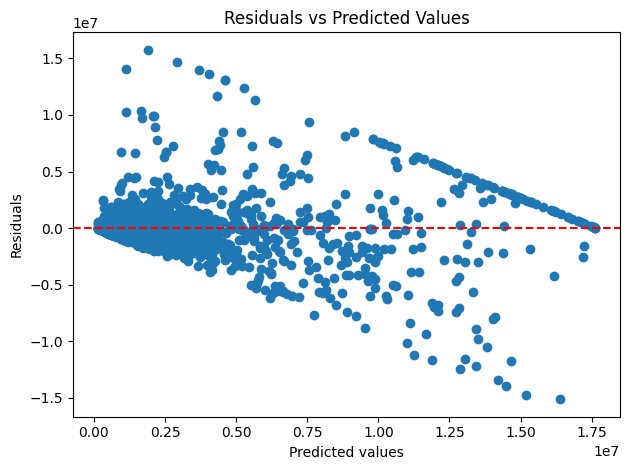

In [128]:
residuals = y_test_top - y_pred_best

#plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.tight_layout()
plt.show()

Heteroscedasticity issue:
he spread of residuals decreases as predicted values increase (funnel shape), suggesting the model's prediction error varies with the magnitude of predictions
There's a downward trend in the residuals, meaning the model tends to overpredict at higher values and underpredict at lower values
The residuals aren't evenly distributed around zero, particularly at the extremes

best_model_"fill in blank" - just means the tuned hyperparameters from the grid search were used.

<font size='3'> Log Transform Target Variable Model </font>

In [129]:
y_train_log = np.log1p(y_train_top)

best_model_log = best_model.fit(X_train_top, y_train_log)
y_pred_log = best_model_log.predict(X_valid_top)
y_pred_original = np.expm1(y_pred_log)

mae_valid_log = mean_absolute_error(y_valid_top, y_pred_original)
r2_valid_log = r2_score(y_valid_top, y_pred_original)

print(f'Mean Absolute Error (Log-transformed) on Validation Set: {mae_valid_log}')
print(f'R² (Log-transformed) on Validation Set: {r2_valid_log}')

Mean Absolute Error (Log-transformed) on Validation Set: 579392.3318793576
R² (Log-transformed) on Validation Set: 0.6948208076539724


Text(0, 0.5, 'Residuals')

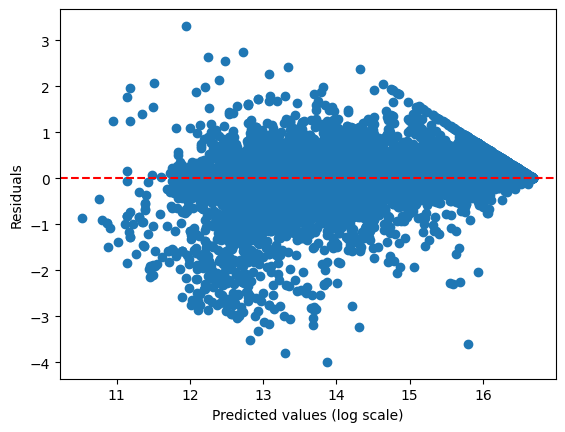

In [130]:
residuals_log = y_train_log - best_model_log.predict(X_train_top)

plt.scatter(best_model_log.predict(X_train_top), residuals_log)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values (log scale)')
plt.ylabel('Residuals')

<font size='3'> Outliers Capped at 2 Z-Scores </font>

In [131]:
best_model_capped = best_model.fit(X_train_top, capped_initial_train_y)

y_pred_capped = best_model_capped.predict(X_valid_top)

mae_test_capped = mean_absolute_error(capped_initial_valid_y, y_pred_capped)
r2_test_capped = r2_score(capped_initial_valid_y, y_pred_capped)

print(f'Mean Absolute Error (Capped): {mae_test_capped}')
print(f'R² (Capped): {r2_test_capped}')

Mean Absolute Error (Capped): 368900.98231303634
R² (Capped): 0.7149916462039823


<font size='3'> Remove data with outlier sale prices: 2 Z-scores Model </font>
- Create masks to remove corresponding x values

In [132]:
z_train_y = zscore(y_train_top.copy())
z_valid_y = zscore(y_valid_top.copy())
z_test_y = zscore(y_test_top.copy())

threshold = 2

train_mask = np.abs(z_train_y) <= threshold
valid_mask = np.abs(z_valid_y) <= threshold
test_mask = np.abs(z_test_y) <= threshold

y_train_clean = y_train_top[train_mask].copy()
y_valid_clean = y_valid_top[valid_mask].copy()
y_test_clean = y_test_top[test_mask].copy()

X_train_clean = X_train_top[train_mask].copy()
X_valid_clean = X_valid_top[valid_mask].copy()
X_test_clean = X_test_top[test_mask].copy()

In [133]:
best_model_z = best_model.fit(X_train_clean, y_train_clean)

y_pred_z = best_model_z.predict(X_valid_clean)

mae_test_z = mean_absolute_error(y_valid_clean, y_pred_z)  
r2_test_z = r2_score(y_valid_clean, y_pred_z)

print(f'Mean Absolute Error (Outliers Removed): {mae_test_z}')
print(f'R² (Outliers Removed): {r2_test_z}')

Mean Absolute Error (Outliers Removed): 349460.3908682456
R² (Outliers Removed): 0.6425263230522047


<font size='4' > Gradient Boosting </font>

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

<font size='3'> Initial Model </font>
- Starting from the RF reduced features.

In [135]:
gb_model = GradientBoostingRegressor(random_state=13)
gb_model.fit(X_train_top, y_train_top)

y_pred_gb = gb_model.predict(X_valid_top)

mae_gb = mean_absolute_error(y_valid_top, y_pred_gb)
r2_gb = r2_score(y_valid_top, y_pred_gb)

print(f'Mean Absolute Error (Initial Gradient Model): {mae_gb}')
print(f'R² (Initial Gradient Model): {r2_gb}')

Mean Absolute Error (Initial Gradient Model): 660615.7357313711
R² (Initial Gradient Model): 0.65551938764059


<font size='3'> Hyperparameter Tuning </font>

In [136]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss': ['squared_error', 'absolute_error']}

In [137]:
#gb = GradientBoostingRegressor(random_state=13)

#kf = KFold(n_splits=3, shuffle=True, random_state=13)
#gb_random = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, n_iter=50, cv=kf, random_state=13, verbose=1, n_jobs=2)
#gb_random.fit(X_train_top, y_train_top)

In [138]:
#best_gb_model = gb_random.best_estimator_
#best_gb_params = gb_random.best_params_
#best_gb_params

In [139]:
#Save
#joblib.dump(gb_random, 'gradient_boosting_model.pkl')

In [140]:
#Load
gb_random = joblib.load('gradient_boosting_model.pkl')
best_gb_model = gb_random.best_estimator_
best_gb_params = gb_random.best_params_

<font size='3'> Evaluate Optimized Model </font>

In [141]:
y_pred_best_gb = best_gb_model.predict(X_test_top)

mae_test_gb = mean_absolute_error(y_test_top, y_pred_best_gb)
r2_test_gb = r2_score(y_test_top, y_pred_best_gb)

print(f'Mean Absolute Error (Optimized GB Model): {mae_test_gb}')
print(f'R² (Optimized GB Model): {r2_test_gb}')

Mean Absolute Error (Optimized GB Model): 561106.1985742782
R² (Optimized GB Model): 0.7196438172259709


<font size='3'> Capping outliers at second z score </font>

In [142]:
best_gb_model_capped = best_gb_model.fit(X_train_top, capped_initial_train_y)

y_pred_gb_capped = best_gb_model_capped.predict(X_valid_top)

mae_test_gb_capped = mean_absolute_error(capped_initial_valid_y, y_pred_gb_capped)
r2_test_gb_capped = r2_score(capped_initial_valid_y, y_pred_gb_capped)

print(f'Mean Absolute Error (Capped): {mae_test_gb_capped}')
print(f'R² (Capped): {r2_test_gb_capped}')

Mean Absolute Error (Capped): 380710.5387272713
R² (Capped): 0.6797832604325844


<font size='4'> Extreme Gradient Boosting </font>

In [143]:
from xgboost import XGBRegressor

In [144]:
X_train_xgb = X_train_top.copy()
X_valid_xgb = X_valid_top.copy()
X_test_xgb = X_test_top.copy()

<font size='3'> Initial Model </font>

In [145]:
xgb_model = XGBRegressor(n_estimators=100, random_state=13)
xgb_model.fit(X_train_xgb, y_train_top)

y_pred_xgb = xgb_model.predict(X_valid_xgb)

mae_xgb = mean_absolute_error(y_valid_top, y_pred_xgb)
r2_xgb = r2_score(y_valid_top, y_pred_xgb)

print(f'Mean Absolute Error (Initial XGB Model): {mae_xgb}')
print(f'R² (Initial XGB Model): {r2_xgb}')

Mean Absolute Error (Initial XGB Model): 614486.6604666109
R² (Initial XGB Model): 0.7027590653340711


<font size='3'> Hyperparameter Tuning </font>

In [146]:
param_grid = {
    'n_estimators': [100,200,300],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [8,10,15],
    'min_child_weight': [1,3,5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [147]:
#xgb = XGBRegressor(n_estimators=100, random_state=13)

#kf=KFold(n_splits=3, shuffle=True, random_state=13)
#xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=150, cv=kf, random_state=13, verbose=1, n_jobs=2)
#xgb_random.fit(X_train_xgb, y_train_top)

In [148]:
#best_xgb_model = xgb_random.best_estimator_
#best_xgb_params = xgb_random.best_params_
#best_xgb_params

In [149]:
#Save
#joblib.dump(xgb_random, 'extreme_gradient_boosting_model.pkl')

In [150]:
#Load
xgb_random = joblib.load('extreme_gradient_boosting_model.pkl')
best_xgb_model = xgb_random.best_estimator_
best_xgb_params = xgb_random.best_params_

<font size='3'> Evaluate Optimized Model </font>

In [151]:
y_pred_best_xgb= best_xgb_model.predict(X_valid_xgb)

mae_best_xgb = mean_absolute_error(y_valid_top, y_pred_best_xgb)
r2_best_xgb = r2_score(y_valid_top, y_pred_best_xgb)

print(f'Mean Absolute Error (Optimized XGB Model): {mae_best_xgb}')
print(f'R² (Optimized XGB Model): {r2_best_xgb}')

Mean Absolute Error (Optimized XGB Model): 572651.3718275038
R² (Optimized XGB Model): 0.7341114605674453


<font size='3'> Capped Outlier Model </font>

In [152]:
best_xgb_model_capped = best_gb_model.fit(X_train_xgb, capped_initial_train_y)

y_pred_xgb_capped = best_xgb_model_capped.predict(X_valid_xgb)

mae_capped_xgb = mean_absolute_error(capped_initial_valid_y, y_pred_xgb_capped)
r2_capped_xgb = r2_score(capped_initial_valid_y, y_pred_xgb_capped)

print(f'Mean Absolute Error (Capped XGB Model): {mae_capped_xgb}')
print(f'R² (Capped XGB Model): {r2_capped_xgb}')

Mean Absolute Error (Capped XGB Model): 380710.5387272713
R² (Capped XGB Model): 0.6797832604325844


<font size='4'> K-Nearest Neighbors </font>

In [153]:
from sklearn.neighbors import KNeighborsRegressor

Standardize X_train_top

In [154]:
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_top).copy()
X_valid_knn = scaler.transform(X_valid_top).copy()
X_test_knn = scaler.transform(X_test_top).copy()

<font size='3'> Initial Model </font>

In [155]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_top)

y_pred_knn= knn_model.predict(X_valid_knn)

mae_knn = mean_absolute_error(y_valid_top, y_pred_knn)
r2_knn = r2_score(y_valid_top, y_pred_knn)

print(f'Mean Absolute Error (Initial KNN Model): {mae_knn}')
print(f'R² (Initial KNN Model): {r2_knn}')

Mean Absolute Error (Initial KNN Model): 652023.7933800605
R² (Initial KNN Model): 0.6572854993207558


<font size ='3'> Hyperparameter Tuning

In [156]:
param_grid = {
    'n_neighbors': [3, 5, 7, 11, 15], 
    'weights': ['uniform', 'distance'], 
    'p': [1, 2, 3], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

In [157]:
#knn = KNeighborsRegressor()

#kf = KFold(n_splits=3, shuffle=True, random_state=13)
#knn_random = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, n_iter=150, cv=kf, random_state=13, verbose=1, n_jobs=2)
#knn_random.fit(X_train_knn, y_train_top)

In [158]:
#best_knn_model = knn_random.best_estimator_
#best_knn_params = knn_random.best_params_
#best_knn_params

In [159]:
#Save
#joblib.dump(knn_random, 'k_nearest_neighbors_model.pkl')

In [160]:
#Load
knn_random = joblib.load('k_nearest_neighbors_model.pkl')
best_knn_model = knn_random.best_estimator_
best_knn_params = knn_random.best_params_

<font size='3' > Evaluate Optimized Model </font>

In [161]:
y_pred_best_knn = best_knn_model.predict(X_valid_knn)

mae_best_knn = mean_absolute_error(y_valid_top, y_pred_best_knn) 
r2_best_knn = r2_score(y_valid_top, y_pred_best_knn)

print(f'Mean Absolute Error (Optimized KNN Model): {mae_best_knn}')
print(f'R² (Optimized KNN Model): {r2_best_knn}')

Mean Absolute Error (Optimized KNN Model): 630296.9218930047
R² (Optimized KNN Model): 0.6559351218590658


<font size='3'> Capping Outliers at second Z-score </font>

In [162]:
best_knn_model_capped = best_knn_model.fit(X_train_knn, capped_initial_train_y)

y_pred_knn_capped = best_knn_model_capped.predict(X_valid_knn)

mae_capped_knn = mean_absolute_error(capped_initial_valid_y, y_pred_knn_capped)
r2_capped_knn = r2_score(capped_initial_valid_y, y_pred_knn_capped)

print(f'Mean Absolute Error (Capped KNN Model): {mae_capped_knn}')
print(f'R² (Capped KNN Model): {r2_capped_knn}')

Mean Absolute Error (Capped KNN Model): 398237.2732980574
R² (Capped KNN Model): 0.6539045425914789


<font size='4'> Support Vector Regression </font>

In [163]:
from sklearn.svm import SVR

<font size='3'> Initial Model </font>

In [164]:
X_train_svr = X_train_knn.copy()
X_valid_svr = X_valid_knn.copy()
X_test_svr = X_test_knn.copy()

In [165]:
svr_model = SVR()
svr_model.fit(X_train_svr, y_train_top)

y_pred_svr = svr_model.predict(X_valid_svr)

mae_svr = mean_absolute_error(y_valid_top, y_pred_svr)
r2_svr = r2_score(y_valid_top, y_pred_svr)

print(f'Mean Absolute Error (Initial SVR Model): {mae_svr}')
print(f'R² (Initial SVR Model): {r2_svr}')

Mean Absolute Error (Initial SVR Model): 1060770.5735348598
R² (Initial SVR Model): -0.08689885533120578


<font size='4'> Neural Network </font>

In [166]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [167]:
X_train_nnr = X_train_knn.copy()
X_valid_nnr = X_valid_knn.copy()
X_test_nnr = X_test_knn.copy()

y_train_nnr = y_train_top.copy()
y_valid_nnr = y_valid_top.copy()

X_train_nnr = torch.tensor(X_train_nnr, dtype=torch.float32)
X_valid_nnr = torch.tensor(X_valid_nnr, dtype=torch.float32)
X_test_nnr = torch.tensor(X_test_nnr, dtype=torch.float32)

y_train_nnr = torch.tensor(y_train_top.values, dtype=torch.float32)
y_valid_nnr = torch.tensor(y_valid_top.values, dtype=torch.float32)

<font size='3'> Initial Model </font>

In [168]:
nnr_model = nn.Sequential(
    nn.Linear(X_train_nnr.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32,1)
)

In [169]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nnr_model.parameters(), lr=0.001, weight_decay=0.0001)

In [170]:
num_epochs = 70
patience = 5
best_loss = float('inf')
epochs_without_improvement_count = 0 

# Train Loop
for epoch in range(num_epochs):
    nnr_model.train()
    y_pred_train_nnr = nnr_model(X_train_nnr).squeeze() 
    loss = criterion(y_pred_train_nnr, y_train_nnr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

# Eval Loop
    nnr_model.eval()  
    y_pred_val_nnr = nnr_model(X_valid_nnr).squeeze() 
    val_loss = criterion(y_pred_val_nnr, y_valid_nnr).item()

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_without_improvement_count = 0  
    else:
        epochs_without_improvement_count += 1

    if epochs_without_improvement_count >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

nnr_model.eval()  
y_pred_nnr = nnr_model(X_valid_nnr).squeeze() 

mae_nnr = mean_absolute_error(y_valid_nnr, y_pred_nnr.detach().numpy())
print(f"Validation MAE: {mae_nnr}")

Epoch [0/70], Loss: 9677629816832.0
Early stopping at epoch 9
Validation MAE: 1563009.625


<font size='3'> Hyperparameter Tuning </font>

In [171]:
import torch.nn.init as init

In [172]:
nnr_model = nn.Sequential(
    nn.Linear(X_train_nnr.shape[1], 256),  # Reduced neurons
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),  # Added dropout
    
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.2),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.2),
    
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Dropout(0.2),
    
    nn.Linear(32, 1)  # Output layer
)

# Initialize weights with He initialization
for layer in nnr_model:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, a=0.1)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

In [173]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nnr_model.parameters(), lr=0.01, weight_decay=0.0005)

In [174]:
num_epochs = 200
patience = 20
best_loss = float('inf')
epochs_without_improvement_count = 0 

# Train Loop
for epoch in range(num_epochs):
    nnr_model.train()
    y_pred_train_nnr = nnr_model(X_train_nnr).squeeze() 
    loss = criterion(y_pred_train_nnr, y_train_nnr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

# Eval Loop
    nnr_model.eval()  
    y_pred_val_nnr = nnr_model(X_valid_nnr).squeeze() 
    val_loss = criterion(y_pred_val_nnr, y_valid_nnr).item()

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_without_improvement_count = 0  
    else:
        epochs_without_improvement_count += 1

    if epochs_without_improvement_count >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

nnr_model.eval()  
y_pred_nnr = nnr_model(X_valid_nnr).squeeze() 

mae_nnr = mean_absolute_error(y_valid_nnr, y_pred_nnr.detach().numpy())
print(f"Validation MAE: {mae_nnr}")

Epoch [0/200], Loss: 9677630865408.0
Epoch [10/200], Loss: 9677598359552.0
Epoch [20/200], Loss: 9677573193728.0
Early stopping at epoch 29
Validation MAE: 1563009.375


Feature Selected Model

In [175]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(score_func=f_regression, k=1)
X_train_nnr_selected = selector.fit_transform(X_train_knn, y_train_top)
X_valid_nnr_selected = selector.transform(X_valid_knn)
X_test_nnr_selected = selector.transform(X_test_knn)

X_train_nnr_selected = torch.tensor(X_train_nnr_selected, dtype=torch.float32)
X_valid_nnr_selected = torch.tensor(X_valid_nnr_selected, dtype=torch.float32)
X_test_nnr_selected = torch.tensor(X_test_nnr_selected, dtype=torch.float32)

<font size='4'> Stacking </font>

In [176]:
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict


<font size='3'> Initial Model </font>

In [177]:
# Load  
meta_model = joblib.load('meta_model.pkl')  

In [178]:
kf = KFold(n_splits=5, shuffle=True, random_state=13)
splits = list(kf.split(X_train_top, y_train_top))

xgb_stacked_model = XGBRegressor(**best_xgb_params)
rf_stacked_model = RandomForestRegressor(**best_params)
lasso_stacked_model = Lasso(alpha=100, max_iter=10000)

xgb_preds = cross_val_predict(xgb_stacked_model, X_train_top, y_train_top, cv=splits, n_jobs=-1,)
rf_preds = cross_val_predict(rf_stacked_model, X_train_top, y_train_top, cv=splits, n_jobs=-1)
lasso_preds = cross_val_predict(lasso_stacked_model, X_train_top, y_train_top, cv=splits, n_jobs=-1)

base_model_preds = np.column_stack((xgb_preds, rf_preds, lasso_preds))

meta_initial_model = LinearRegression()
meta_initial_model.fit(base_model_preds, y_train_top)

LinearRegression()

In [179]:
xgb_stacked_model.fit(X_train_top, y_train_top)
rf_stacked_model.fit(X_train_top, y_train_top)
lasso_stacked_model.fit(X_train_top, y_train_top)

xgb_stacked_preds = xgb_stacked_model.predict(X_valid_top)
rf_stacked_preds = rf_stacked_model.predict(X_valid_top)
lasso_stacked_preds = lasso_stacked_model.predict(X_valid_top)

base_model_stacked_preds = np.column_stack((xgb_stacked_preds, rf_stacked_preds, lasso_stacked_preds))

final_preds = meta_model.predict(base_model_stacked_preds)

In [180]:
mae = mean_absolute_error(y_valid_top, final_preds)
r2 = r2_score(y_valid_top, final_preds)

print(f'Mean Absolute Error: (Meta Model): {mae}')
print(f'R² Score: (Meta Model): {r2}')

Mean Absolute Error: (Meta Model): 572038.193519323
R² Score: (Meta Model): 0.7366582045226637


In [181]:
#Save
#joblib.dump(meta_initial_model, 'meta_model.pkl')

<font size='5'> Stacked Model: The Best Model! </font>

<font size='4'> Final Model Evaluation </font>

Test Set

In [182]:
xgb_test_preds = xgb_stacked_model.predict(X_test_top)
rf_test_preds = rf_stacked_model.predict(X_test_top)
lasso_test_preds = lasso_stacked_model.predict(X_test_top)

base_model_test_preds = np.column_stack((xgb_test_preds, rf_test_preds, lasso_test_preds))

final_test_preds = meta_model.predict(base_model_test_preds)

test_mae = mean_absolute_error(y_test_top, final_test_preds)
test_r2 = r2_score(y_test_top, final_test_preds)

print(f"Test MAE: {test_mae}")
print(f"Test R²: {test_r2}")

Test MAE: 582007.0874950645
Test R²: 0.7259992118190381


Feature Importance

In [183]:
xgb_importances = xgb_stacked_model.feature_importances_
sorted_indices_xgb = np.argsort(xgb_importances)[::-1]

print("Top 5 Features from Extreme Gradient Boosting:\n")
for i in sorted_indices_xgb[:5]:
    print(f'{X_train_top.columns[i]}: {xgb_importances[i]:.3f}')

Top 5 Features from Extreme Gradient Boosting:

borough_manhattan: 0.097
building_class_at_time_of_sale_b2: 0.047
sub_category_Residential - Condominiums: 0.042
gross_square_feet: 0.039
building_class_at_time_of_sale_h7: 0.034


In [184]:
rf_importances = rf_stacked_model.feature_importances_
sorted_indices_rf = np.argsort(rf_importances)[::-1]

print("Top 5 Features from Random Forest:\n")
for i in sorted_indices_rf[:5]:
    print(f'{X_train_top.columns[i]}: {rf_importances[i]:.3f}')

Top 5 Features from Random Forest:

gross_square_feet: 0.612
borough_manhattan: 0.112
land_square_feet: 0.067
total_units: 0.052
month: 0.048


In [185]:
lasso_importances = np.abs(lasso_stacked_model.coef_)
sorted_indices_lasso = np.argsort(lasso_importances)[::-1]

print("Top 5 Features from Lasso:\n")
for i in sorted_indices_lasso[:5]:
    print(f'{X_train_top.columns[i]}: {lasso_importances[i]:.0f}')

Top 5 Features from Lasso:

building_class_at_time_of_sale_j2: 11602038
building_class_at_time_of_sale_f2: 10910142
building_class_at_time_of_sale_h7: 10229713
building_class_at_time_of_sale_a7: 7774883
building_class_at_time_of_sale_h3: 7739919


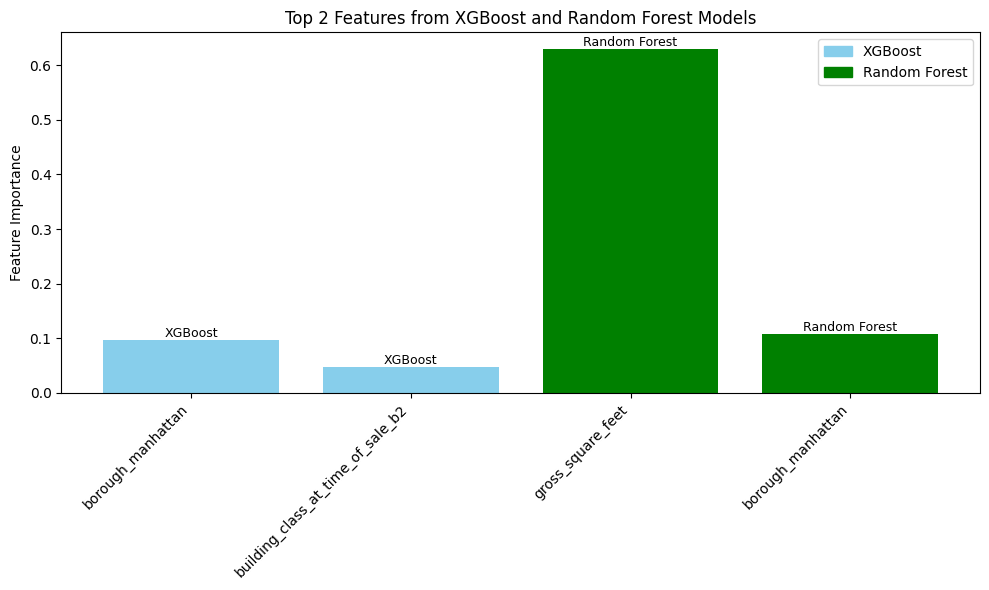

In [186]:
xgb_features = ['borough_manhattan', 'building_class_at_time_of_sale_b2']
xgb_importances = [0.09665260463953018, 0.04710574448108673]
rf_features = ['gross_square_feet', 'borough_manhattan']
rf_importances = [0.6289693747942797, 0.10728636181638299]

all_features = xgb_features + rf_features  # Combine feature names
all_importances = xgb_importances + rf_importances  # Combine importance values
models = ['XGBoost'] * len(xgb_features) + ['Random Forest'] * len(rf_features)  # Assign model labels
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(all_features))
bars = ax.bar(x, all_importances, color=['skyblue' if model == 'XGBoost' else 'green' for model in models])

ax.set_xticks(x)
ax.set_xticklabels(all_features, rotation=45, ha='right')  # Rotate feature names for readability
ax.set_ylabel('Feature Importance')
ax.set_title('Top 2 Features from XGBoost and Random Forest Models')

for bar, model in zip(bars, models):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, model, ha='center', va='bottom', fontsize=9)

ax.legend(handles=[plt.Rectangle((0, 0), 1, 1, color='skyblue', label='XGBoost'),
                  plt.Rectangle((0, 0), 1, 1, color='green', label='Random Forest')])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(final_preds, residuals, color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Prediction Errors vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Prediction Errors (Residuals)')
plt.legend()
plt.show()

Research Question: To what extent can property sale price be predicted?

Null Hypothesis: New York City property sales cannot be predicted from historical sales data with over 75% accuracy.

Alternate Hypothesis: New York City property sales can be predicted from historical sales data with over 75% accuracy.

In [229]:
threshold = 30

y_valid_top = np.where(y_valid_top == 0, np.nan, y_valid_top)
percentage_errors = np.abs((final_preds - y_valid_top) / y_valid_top) * 100
within_threshold = np.sum(percentage_errors <= threshold)
accuracy_percentage = (within_threshold / len(y_valid_top[~np.isnan(y_valid_top)])) * 100

print(f"Percentage of predictions within {threshold}% of true values: {accuracy_percentage:.2f}%")

Percentage of predictions within 30% of true values: 58.9416695773664%


In [234]:
min_y = np.nanmin(y_valid_top)
max_y = np.nanmax(y_valid_top)
range_y = max_y - min_y
mean_y = np.nanmean(y_valid_top)
std_y = np.nanstd(y_valid_top)

print(f"Range of target values: {min_y:.2f} to {max_y:.2f}")
print(f"Range of target values: {range_y:.2f}")
print(f"Mean of target values: {mean_y:.2f}")
print(f"Standard deviation of target values: {std_y:.2f}")

Range of target values: 10500.00 to 17653311.70
Range of target values: 17642811.70
Mean of target values: 1563009.94
Standard deviation of target values: 2727616.35


Random Forest Capped model threshold evaluation just for context.


In [240]:
percentage_errors_capped = np.abs((y_pred_capped - capped_initial_valid_y) / capped_initial_valid_y) * 100
within_threshold_capped = np.sum(percentage_errors_capped <= threshold)
accuracy_percentage_capped = (within_threshold_capped / len(capped_initial_valid_y[~np.isnan(capped_initial_valid_y)])) * 100
print(f"Percentage of RF capped predictions within {threshold}% of true values: {accuracy_percentage_capped:.2f}%")

Percentage of RF capped predictions within 30% of true values: 62.07%


In [243]:
date_range = house['sale_date'].min(), house['sale_date'].max()
print(f"Date range: {date_range[0]} to {date_range[1]}")

Date range: 2018-11-01 to 2019-10-31
